In [1]:
##THE HYBRID WITH SLIME AND IALS RESULTS ARE BETTER THAN ANY OTHER ALGORITHM TESTED BEFORE
import os

os.chdir('/Users/gabriele/PycharmProjects/RecSys')
from Utils.utils import create_URM, create_ICM, combine_matrices, create_submission, write_submission
from src.Evaluation.Evaluator import EvaluatorHoldout
from src.Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
##NON-PERSONALIZED
from src.Recommenders.Base.NonPersonalizedRecommender import TopPop

#KNN
from src.Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from src.Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from src.Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from src.Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from src.Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender

#MATRIX-FACTORIZATION
from src.Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from src.Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from src.Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_FunkSVD_Cython, MatrixFactorization_AsySVD_Cython
from src.Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from src.Recommenders.MatrixFactorization.IALSRecommenderLinear import IALSRecommender
from src.Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

#GRAPHIC-BASED
from src.Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from src.Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender

#HYBRID
from src.Hybrids.MergingModelsByScores import MergeThreeModelsByScores, MergeTwoModelsByScores

In [2]:
##CREATION OF MATRICES AND SPLITTING IN TRAIN-TEST-VALIDATION
URM = create_URM()
ICM = create_ICM()
URM_stacked = combine_matrices(ICM=ICM, URM=URM)

In [3]:
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage=0.85)
stacked_train = combine_matrices(ICM=ICM, URM=URM_train)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13632 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 13632 ( 0.1%) Users that have less than 1 test interactions


In [4]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([115, 430,  95, ..., 180, 136, 234], dtype=int32), (13650,))

In [5]:
block_size = int(len(profile_length)*0.05)
block_size

682

In [6]:
sorted_users = np.argsort(profile_length)
sorted_users

array([11326,   758,  3075, ...,  1141,  8526,   317])

In [7]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 682, average p.len 29.23, median 29.0, min 2, max 50
Group 1, #users in group 682, average p.len 66.19, median 67.0, min 50, max 81
Group 2, #users in group 682, average p.len 94.41, median 95.0, min 81, max 107
Group 3, #users in group 682, average p.len 118.38, median 118.0, min 107, max 129
Group 4, #users in group 682, average p.len 139.30, median 139.0, min 129, max 150
Group 5, #users in group 682, average p.len 158.44, median 158.5, min 150, max 167
Group 6, #users in group 682, average p.len 176.34, median 176.0, min 167, max 186
Group 7, #users in group 682, average p.len 196.23, median 196.0, min 186, max 206
Group 8, #users in group 682, average p.len 216.61, median 217.0, min 206, max 226
Group 9, #users in group 682, average p.len 235.80, median 236.0, min 226, max 245
Group 10, #users in group 682, average p.len 255.10, median 255.0, min 245, max 266
Group 11, #users in group 682, average p.len 276.79, median 277.0, min 266, max 288
Group 12, #use

In [8]:
##CREATION OF DIFFERENT RECOMMENDERS TUNED

### RP3Beta Recommender
RP3Beta_recommender = RP3betaRecommender(URM_train=URM_train)
RP3Beta_recommender.fit(topK=181, alpha=0.5709402717259106, beta=0.3566066452521787, implicit=True, normalize_similarity=True)

In [9]:
##SLIMELASTICNET Recommender
SLIME_recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train=stacked_train)
SLIME_recommender.fit(topK=420, l1_ratio=0.06061216785568925, alpha=0.00554982938879437, workers = 10)

100%|████████████████████████████████████▉| 18032/18059 [07:42<00:00, 71.02it/s]

In [10]:
## IALS Recommender
IALS_recommender = IALSRecommender(URM_train=stacked_train)
IALS_recommender.fit(epochs=10, num_factors=42, alpha=0.7617528864750021, reg=8.926401306541349)

IALSRecommenderLinear: Epoch 1 of 10. Elapsed time 7.07 sec
IALSRecommenderLinear: Epoch 2 of 10. Elapsed time 14.18 sec


100%|████████████████████████████████████▉| 18056/18059 [08:00<00:00, 71.02it/s]

IALSRecommenderLinear: Epoch 3 of 10. Elapsed time 21.26 sec
IALSRecommenderLinear: Epoch 4 of 10. Elapsed time 28.18 sec
IALSRecommenderLinear: Epoch 5 of 10. Elapsed time 34.94 sec
IALSRecommenderLinear: Epoch 6 of 10. Elapsed time 41.81 sec
IALSRecommenderLinear: Epoch 7 of 10. Elapsed time 48.83 sec
IALSRecommenderLinear: Epoch 8 of 10. Elapsed time 55.70 sec
IALSRecommenderLinear: Epoch 9 of 10. Elapsed time 1.04 min
IALSRecommenderLinear: Epoch 10 of 10. Elapsed time 1.16 min
IALSRecommenderLinear: Terminating at epoch 10. Elapsed time 1.16 min


In [11]:
##P3ALPHA Recommender
P3Alpha_recommender = P3alphaRecommender(URM_train=stacked_train)
P3Alpha_recommender.fit(topK=46,alpha=0.7723235971713814, implicit=True, normalize_similarity=False)

In [12]:
##UserKNNCF
UserKNNCF_recommender = UserKNNCFRecommender(URM_train = stacked_train)
UserKNNCF_recommender.fit(topK=450, shrink=5.0, similarity="tanimoto")

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13984 (100.0%), 1082.56 column/sec. Elapsed time 12.92 sec


In [13]:
hybrid1_recommenders = [RP3Beta_recommender, IALS_recommender, SLIME_recommender]

##SLIME_RP3BETA_IALS
SLIM_RP3_IALS_recommender = MergeThreeModelsByScores(stacked_train,hybrid1_recommenders)
SLIM_RP3_IALS_recommender.fit(alpha=0.0, beta=0.3023745211799622, gamma=1.0)

In [40]:
##RP3BETA_USERCF
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0),
    "beta": Real(0.0, 1.0)
}
recommenders = [IALS_recommender, RP3Beta_recommender]

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train, recommenders],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=MergeTwoModelsByScores,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 200
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=MergeTwoModelsByScores.RECOMMENDER_NAME,
                    save_model="best"
                    )





Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.8057009837292863, 'beta': 0.02625492258478513}
EvaluatorHoldout: Processed 13629 (100.0%) in 10.09 sec. Users per second: 1351
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.8057009837292863, 'beta': 0.02625492258478513} - results: PRECISION: 0.2395113, PRECISION_RECALL_MIN_DEN: 0.2440921, RECALL: 0.0693365, MAP: 0.1189597, MAP_MIN_DEN: 0.1214195, MRR: 0.4770308, NDCG: 0.2511941, F1: 0.1075408, HIT_RATE: 0.9167951, ARHR_ALL_HITS: 0.7502199, NOVELTY: 0.0055544, AVERAGE_POPULARITY: 0.5136155, DIVERSITY_MEAN_INTER_LIST: 0.9345654, DIVERSITY_HERFINDAHL: 0.9934497, COVERAGE_ITEM: 0.0527161, COVERAGE_ITEM_CORRECT: 0.0428041, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9153846, DIVERSITY_GINI: 0.0117182, SHANNON_ENTROPY: 8.0763866, RATIO_DIVERSITY_HERFINDAHL: 0.9938232, RATIO_DIVERSITY_GINI: 0.0452091, RATIO_SHANNON_ENTROPY: 0.6490498, RATIO_AVERAGE_POPULARI

EvaluatorHoldout: Processed 13629 (100.0%) in 9.65 sec. Users per second: 1412
SearchBayesianSkopt: Config 6 is suboptimal. Config: {'alpha': 0.14896215040027364, 'beta': 0.5110527322672372} - results: PRECISION: 0.2316678, PRECISION_RECALL_MIN_DEN: 0.2396107, RECALL: 0.0708999, MAP: 0.1123855, MAP_MIN_DEN: 0.1166074, MRR: 0.4607942, NDCG: 0.2433996, F1: 0.1085722, HIT_RATE: 0.9145205, ARHR_ALL_HITS: 0.7174010, NOVELTY: 0.0055884, AVERAGE_POPULARITY: 0.5437282, DIVERSITY_MEAN_INTER_LIST: 0.8724952, DIVERSITY_HERFINDAHL: 0.9872431, COVERAGE_ITEM: 0.0923639, COVERAGE_ITEM_CORRECT: 0.0620743, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9131136, DIVERSITY_GINI: 0.0097922, SHANNON_ENTROPY: 7.5325890, RATIO_DIVERSITY_HERFINDAHL: 0.9876143, RATIO_DIVERSITY_GINI: 0.0377786, RATIO_SHANNON_ENTROPY: 0.6053482, RATIO_AVERAGE_POPULARITY: 2.7436601, RATIO_NOVELTY: 0.0292348, 

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 9.8138
Function value obtained: -0.1124
Current m

EvaluatorHoldout: Processed 13629 (100.0%) in 10.01 sec. Users per second: 1361
SearchBayesianSkopt: Config 13 is suboptimal. Config: {'alpha': 0.4113707538810012, 'beta': 0.8753293852535794} - results: PRECISION: 0.2347788, PRECISION_RECALL_MIN_DEN: 0.2419985, RECALL: 0.0709111, MAP: 0.1147071, MAP_MIN_DEN: 0.1186417, MRR: 0.4664114, NDCG: 0.2466584, F1: 0.1089236, HIT_RATE: 0.9169418, ARHR_ALL_HITS: 0.7290556, NOVELTY: 0.0055699, AVERAGE_POPULARITY: 0.5426351, DIVERSITY_MEAN_INTER_LIST: 0.8834824, DIVERSITY_HERFINDAHL: 0.9883418, COVERAGE_ITEM: 0.0787419, COVERAGE_ITEM_CORRECT: 0.0552079, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9155311, DIVERSITY_GINI: 0.0098815, SHANNON_ENTROPY: 7.6132594, RATIO_DIVERSITY_HERFINDAHL: 0.9887133, RATIO_DIVERSITY_GINI: 0.0381229, RATIO_SHANNON_ENTROPY: 0.6118311, RATIO_AVERAGE_POPULARITY: 2.7381442, RATIO_NOVELTY: 0.0291380, 

Iteration No: 14 ended. Evaluation done at random point.
Time taken: 10.2006
Function value obtained: -0.1147
Curren

SearchBayesianSkopt: Config 19 is suboptimal. Config: {'alpha': 0.3021145044801575, 'beta': 0.638906296908672} - results: PRECISION: 0.2348522, PRECISION_RECALL_MIN_DEN: 0.2420548, RECALL: 0.0709066, MAP: 0.1147627, MAP_MIN_DEN: 0.1186773, MRR: 0.4666655, NDCG: 0.2467364, F1: 0.1089262, HIT_RATE: 0.9171619, ARHR_ALL_HITS: 0.7294051, NOVELTY: 0.0055697, AVERAGE_POPULARITY: 0.5425875, DIVERSITY_MEAN_INTER_LIST: 0.8836667, DIVERSITY_HERFINDAHL: 0.9883602, COVERAGE_ITEM: 0.0784650, COVERAGE_ITEM_CORRECT: 0.0550972, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9157509, DIVERSITY_GINI: 0.0098830, SHANNON_ENTROPY: 7.6145688, RATIO_DIVERSITY_HERFINDAHL: 0.9887318, RATIO_DIVERSITY_GINI: 0.0381286, RATIO_SHANNON_ENTROPY: 0.6119364, RATIO_AVERAGE_POPULARITY: 2.7379041, RATIO_NOVELTY: 0.0291371, 

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 9.9948
Function value obtained: -0.1148
Current minimum: -0.1193
Iteration No: 21 started. Evaluating function at random point.


SearchBayesianSkopt: Config 26 is suboptimal. Config: {'alpha': 0.5688401088184216, 'beta': 0.03152986508116674} - results: PRECISION: 0.2399149, PRECISION_RECALL_MIN_DEN: 0.2445389, RECALL: 0.0694590, MAP: 0.1190753, MAP_MIN_DEN: 0.1215427, MRR: 0.4767491, NDCG: 0.2514195, F1: 0.1077288, HIT_RATE: 0.9174554, ARHR_ALL_HITS: 0.7503373, NOVELTY: 0.0055542, AVERAGE_POPULARITY: 0.5143498, DIVERSITY_MEAN_INTER_LIST: 0.9338176, DIVERSITY_HERFINDAHL: 0.9933749, COVERAGE_ITEM: 0.0528268, COVERAGE_ITEM_CORRECT: 0.0427488, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9160440, DIVERSITY_GINI: 0.0116789, SHANNON_ENTROPY: 8.0685318, RATIO_DIVERSITY_HERFINDAHL: 0.9937484, RATIO_DIVERSITY_GINI: 0.0450572, RATIO_SHANNON_ENTROPY: 0.6484186, RATIO_AVERAGE_POPULARITY: 2.5954165, RATIO_NOVELTY: 0.0290561, 

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 10.1441
Function value obtained: -0.1191
Current minimum: -0.1193
Iteration No: 28 started. Evaluating function at random poin

SearchBayesianSkopt: Config 33 is suboptimal. Config: {'alpha': 0.2831628018642935, 'beta': 0.15134558038398951} - results: PRECISION: 0.2402524, PRECISION_RECALL_MIN_DEN: 0.2460721, RECALL: 0.0707810, MAP: 0.1190013, MAP_MIN_DEN: 0.1221700, MRR: 0.4752075, NDCG: 0.2521083, F1: 0.1093472, HIT_RATE: 0.9175288, ARHR_ALL_HITS: 0.7492242, NOVELTY: 0.0055521, AVERAGE_POPULARITY: 0.5276065, DIVERSITY_MEAN_INTER_LIST: 0.9175522, DIVERSITY_HERFINDAHL: 0.9917485, COVERAGE_ITEM: 0.0576444, COVERAGE_ITEM_CORRECT: 0.0451852, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9161172, DIVERSITY_GINI: 0.0109635, SHANNON_ENTROPY: 7.9105325, RATIO_DIVERSITY_HERFINDAHL: 0.9921214, RATIO_DIVERSITY_GINI: 0.0422975, RATIO_SHANNON_ENTROPY: 0.6357212, RATIO_AVERAGE_POPULARITY: 2.6623100, RATIO_NOVELTY: 0.0290450, 

Iteration No: 34 ended. Evaluation done at random point.
Time taken: 9.9964
Function value obtained: -0.1190
Current minimum: -0.1193
Iteration No: 35 started. Evaluating function at random point

SearchBayesianSkopt: Config 40 is suboptimal. Config: {'alpha': 0.6512839912111713, 'beta': 0.28169787921462913} - results: PRECISION: 0.2404432, PRECISION_RECALL_MIN_DEN: 0.2460822, RECALL: 0.0706371, MAP: 0.1191315, MAP_MIN_DEN: 0.1222407, MRR: 0.4756285, NDCG: 0.2522330, F1: 0.1091950, HIT_RATE: 0.9169418, ARHR_ALL_HITS: 0.7499204, NOVELTY: 0.0055521, AVERAGE_POPULARITY: 0.5251819, DIVERSITY_MEAN_INTER_LIST: 0.9210637, DIVERSITY_HERFINDAHL: 0.9920996, COVERAGE_ITEM: 0.0565369, COVERAGE_ITEM_CORRECT: 0.0447422, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9155311, DIVERSITY_GINI: 0.0111036, SHANNON_ENTROPY: 7.9432896, RATIO_DIVERSITY_HERFINDAHL: 0.9924726, RATIO_DIVERSITY_GINI: 0.0428379, RATIO_SHANNON_ENTROPY: 0.6383536, RATIO_AVERAGE_POPULARITY: 2.6500752, RATIO_NOVELTY: 0.0290450, 

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 10.6732
Function value obtained: -0.1191
Current minimum: -0.1193
Iteration No: 42 started. Evaluating function at random poin

SearchBayesianSkopt: Config 47 is suboptimal. Config: {'alpha': 0.8506412195692621, 'beta': 0.9812830079763878} - results: PRECISION: 0.2383741, PRECISION_RECALL_MIN_DEN: 0.2450120, RECALL: 0.0711148, MAP: 0.1175131, MAP_MIN_DEN: 0.1211547, MRR: 0.4724519, NDCG: 0.2504466, F1: 0.1095478, HIT_RATE: 0.9180424, ARHR_ALL_HITS: 0.7423943, NOVELTY: 0.0055573, AVERAGE_POPULARITY: 0.5367069, DIVERSITY_MEAN_INTER_LIST: 0.9004421, DIVERSITY_HERFINDAHL: 0.9900376, COVERAGE_ITEM: 0.0665042, COVERAGE_ITEM_CORRECT: 0.0490614, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9166300, DIVERSITY_GINI: 0.0103463, SHANNON_ENTROPY: 7.7562051, RATIO_DIVERSITY_HERFINDAHL: 0.9904098, RATIO_DIVERSITY_GINI: 0.0399164, RATIO_SHANNON_ENTROPY: 0.6233188, RATIO_AVERAGE_POPULARITY: 2.7082303, RATIO_NOVELTY: 0.0290721, 

Iteration No: 48 ended. Evaluation done at random point.
Time taken: 10.3714
Function value obtained: -0.1175
Current minimum: -0.1193
Iteration No: 49 started. Evaluating function at random point

SearchBayesianSkopt: Config 54 is suboptimal. Config: {'alpha': 0.06238251910862648, 'beta': 0.13278892287427949} - results: PRECISION: 0.2347641, PRECISION_RECALL_MIN_DEN: 0.2419838, RECALL: 0.0709102, MAP: 0.1147014, MAP_MIN_DEN: 0.1186353, MRR: 0.4664534, NDCG: 0.2466522, F1: 0.1089209, HIT_RATE: 0.9169418, ARHR_ALL_HITS: 0.7290670, NOVELTY: 0.0055699, AVERAGE_POPULARITY: 0.5426343, DIVERSITY_MEAN_INTER_LIST: 0.8834723, DIVERSITY_HERFINDAHL: 0.9883407, COVERAGE_ITEM: 0.0787419, COVERAGE_ITEM_CORRECT: 0.0552079, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9155311, DIVERSITY_GINI: 0.0098812, SHANNON_ENTROPY: 7.6131834, RATIO_DIVERSITY_HERFINDAHL: 0.9887123, RATIO_DIVERSITY_GINI: 0.0381219, RATIO_SHANNON_ENTROPY: 0.6118250, RATIO_AVERAGE_POPULARITY: 2.7381402, RATIO_NOVELTY: 0.0291382, 

Iteration No: 55 ended. Evaluation done at random point.
Time taken: 11.8223
Function value obtained: -0.1147
Current minimum: -0.1193
Iteration No: 56 started. Evaluating function at random poi

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 10.4483
Function value obtained: -0.1190
Current minimum: -0.1194
Iteration No: 62 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7134705100030334, 'beta': 0.4930980586946838}
EvaluatorHoldout: Processed 13629 (100.0%) in 10.24 sec. Users per second: 1331
SearchBayesianSkopt: Config 61 is suboptimal. Config: {'alpha': 0.7134705100030334, 'beta': 0.4930980586946838} - results: PRECISION: 0.2403184, PRECISION_RECALL_MIN_DEN: 0.2464672, RECALL: 0.0710712, MAP: 0.1188167, MAP_MIN_DEN: 0.1221971, MRR: 0.4745829, NDCG: 0.2521414, F1: 0.1097000, HIT_RATE: 0.9185560, ARHR_ALL_HITS: 0.7480826, NOVELTY: 0.0055529, AVERAGE_POPULARITY: 0.5305784, DIVERSITY_MEAN_INTER_LIST: 0.9127403, DIVERSITY_HERFINDAHL: 0.9912673, COVERAGE_ITEM: 0.0606346, COVERAGE_ITEM_CORRECT: 0.0464588, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9171429, DIVERSITY_GINI: 0.0107961, SHANNON_EN

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 10.3363
Function value obtained: -0.1181
Current minimum: -0.1194
Iteration No: 69 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.786523693156997, 'beta': 0.6833930126050887}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.79 sec. Users per second: 1392
SearchBayesianSkopt: Config 68 is suboptimal. Config: {'alpha': 0.786523693156997, 'beta': 0.6833930126050887} - results: PRECISION: 0.2399002, PRECISION_RECALL_MIN_DEN: 0.2463278, RECALL: 0.0712735, MAP: 0.1183838, MAP_MIN_DEN: 0.1219095, MRR: 0.4737506, NDCG: 0.2517564, F1: 0.1098970, HIT_RATE: 0.9189963, ARHR_ALL_HITS: 0.7462239, NOVELTY: 0.0055540, AVERAGE_POPULARITY: 0.5334635, DIVERSITY_MEAN_INTER_LIST: 0.9075336, DIVERSITY_HERFINDAHL: 0.9907467, COVERAGE_ITEM: 0.0627942, COVERAGE_ITEM_CORRECT: 0.0475109, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9175824, DIVERSITY_GINI: 0.0105933, SHANNON_ENTRO

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 11.8457
Function value obtained: -0.1193
Current minimum: -0.1194
Iteration No: 76 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.5971497617684507, 'beta': 0.5425892140724694}
EvaluatorHoldout: Processed 13629 (100.0%) in 11.18 sec. Users per second: 1219
SearchBayesianSkopt: Config 75 is suboptimal. Config: {'alpha': 0.5971497617684507, 'beta': 0.5425892140724694} - results: PRECISION: 0.2394160, PRECISION_RECALL_MIN_DEN: 0.2459175, RECALL: 0.0712542, MAP: 0.1181372, MAP_MIN_DEN: 0.1217057, MRR: 0.4735940, NDCG: 0.2514230, F1: 0.1098232, HIT_RATE: 0.9189229, ARHR_ALL_HITS: 0.7453680, NOVELTY: 0.0055543, AVERAGE_POPULARITY: 0.5340238, DIVERSITY_MEAN_INTER_LIST: 0.9064638, DIVERSITY_HERFINDAHL: 0.9906397, COVERAGE_ITEM: 0.0631264, COVERAGE_ITEM_CORRECT: 0.0477878, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9175092, DIVERSITY_GINI: 0.0105496, SHANNON_EN

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 10.8941
Function value obtained: -0.1192
Current minimum: -0.1194
Iteration No: 83 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9998370581978794, 'beta': 0.7463270958534299}
EvaluatorHoldout: Processed 13629 (100.0%) in 10.25 sec. Users per second: 1329
SearchBayesianSkopt: Config 82 is suboptimal. Config: {'alpha': 0.9998370581978794, 'beta': 0.7463270958534299} - results: PRECISION: 0.2403991, PRECISION_RECALL_MIN_DEN: 0.2466361, RECALL: 0.0711377, MAP: 0.1186723, MAP_MIN_DEN: 0.1221082, MRR: 0.4732520, NDCG: 0.2519858, F1: 0.1097876, HIT_RATE: 0.9183359, ARHR_ALL_HITS: 0.7466564, NOVELTY: 0.0055528, AVERAGE_POPULARITY: 0.5316276, DIVERSITY_MEAN_INTER_LIST: 0.9110441, DIVERSITY_HERFINDAHL: 0.9910977, COVERAGE_ITEM: 0.0610222, COVERAGE_ITEM_CORRECT: 0.0467357, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9169231, DIVERSITY_GINI: 0.0107137, SHANNON_EN

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 10.6545
Function value obtained: -0.1125
Current minimum: -0.1194
Iteration No: 90 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.5142826035805846, 'beta': 0.17717127579704142}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.80 sec. Users per second: 1391
SearchBayesianSkopt: Config 89 is suboptimal. Config: {'alpha': 0.5142826035805846, 'beta': 0.17717127579704142} - results: PRECISION: 0.2407000, PRECISION_RECALL_MIN_DEN: 0.2460406, RECALL: 0.0703597, MAP: 0.1193344, MAP_MIN_DEN: 0.1222806, MRR: 0.4766028, NDCG: 0.2523974, F1: 0.1088896, HIT_RATE: 0.9176022, ARHR_ALL_HITS: 0.7510892, NOVELTY: 0.0055517, AVERAGE_POPULARITY: 0.5230820, DIVERSITY_MEAN_INTER_LIST: 0.9240717, DIVERSITY_HERFINDAHL: 0.9924004, COVERAGE_ITEM: 0.0555955, COVERAGE_ITEM_CORRECT: 0.0442439, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9161905, DIVERSITY_GINI: 0.0112151, SHANNON_E

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 10.8559
Function value obtained: -0.1115
Current minimum: -0.1194
Iteration No: 97 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.769835097450049, 'beta': 0.16153610738565005}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.67 sec. Users per second: 1410
SearchBayesianSkopt: Config 96 is suboptimal. Config: {'alpha': 0.769835097450049, 'beta': 0.16153610738565005} - results: PRECISION: 0.2402010, PRECISION_RECALL_MIN_DEN: 0.2452552, RECALL: 0.0699989, MAP: 0.1191816, MAP_MIN_DEN: 0.1219829, MRR: 0.4758427, NDCG: 0.2518633, F1: 0.1084063, HIT_RATE: 0.9165750, ARHR_ALL_HITS: 0.7501925, NOVELTY: 0.0055524, AVERAGE_POPULARITY: 0.5193092, DIVERSITY_MEAN_INTER_LIST: 0.9286419, DIVERSITY_HERFINDAHL: 0.9928574, COVERAGE_ITEM: 0.0537682, COVERAGE_ITEM_CORRECT: 0.0434133, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9151648, DIVERSITY_GINI: 0.0114150, SHANNON_ENT

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 10.8420
Function value obtained: -0.1163
Current minimum: -0.1194
Iteration No: 104 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.8831479344764601, 'beta': 0.34918978539796003}
EvaluatorHoldout: Processed 13629 (100.0%) in 10.06 sec. Users per second: 1354
SearchBayesianSkopt: Config 103 is suboptimal. Config: {'alpha': 0.8831479344764601, 'beta': 0.34918978539796003} - results: PRECISION: 0.2406413, PRECISION_RECALL_MIN_DEN: 0.2461169, RECALL: 0.0704978, MAP: 0.1192657, MAP_MIN_DEN: 0.1223188, MRR: 0.4762628, NDCG: 0.2523935, F1: 0.1090488, HIT_RATE: 0.9173821, ARHR_ALL_HITS: 0.7506912, NOVELTY: 0.0055520, AVERAGE_POPULARITY: 0.5242733, DIVERSITY_MEAN_INTER_LIST: 0.9223429, DIVERSITY_HERFINDAHL: 0.9922275, COVERAGE_ITEM: 0.0559832, COVERAGE_ITEM_CORRECT: 0.0445207, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9159707, DIVERSITY_GINI: 0.0111534, SHANN

Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 11.1277
Function value obtained: -0.1168
Current minimum: -0.1194
Iteration No: 111 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.589945527910224, 'beta': 0.1961858136948928}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.85 sec. Users per second: 1384
SearchBayesianSkopt: Config 110 is suboptimal. Config: {'alpha': 0.589945527910224, 'beta': 0.1961858136948928} - results: PRECISION: 0.2406706, PRECISION_RECALL_MIN_DEN: 0.2459825, RECALL: 0.0703275, MAP: 0.1193545, MAP_MIN_DEN: 0.1222861, MRR: 0.4767987, NDCG: 0.2523948, F1: 0.1088481, HIT_RATE: 0.9179690, ARHR_ALL_HITS: 0.7512402, NOVELTY: 0.0055516, AVERAGE_POPULARITY: 0.5228249, DIVERSITY_MEAN_INTER_LIST: 0.9244475, DIVERSITY_HERFINDAHL: 0.9924380, COVERAGE_ITEM: 0.0554294, COVERAGE_ITEM_CORRECT: 0.0440224, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9165568, DIVERSITY_GINI: 0.0112306, SHANNON_EN

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 11.0761
Function value obtained: -0.1193
Current minimum: -0.1194
Iteration No: 118 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.8927938495215864, 'beta': 0.6425178210044802}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.87 sec. Users per second: 1380
SearchBayesianSkopt: Config 117 is suboptimal. Config: {'alpha': 0.8927938495215864, 'beta': 0.6425178210044802} - results: PRECISION: 0.2404505, PRECISION_RECALL_MIN_DEN: 0.2466412, RECALL: 0.0711127, MAP: 0.1187645, MAP_MIN_DEN: 0.1221750, MRR: 0.4741327, NDCG: 0.2521454, F1: 0.1097632, HIT_RATE: 0.9188495, ARHR_ALL_HITS: 0.7476259, NOVELTY: 0.0055530, AVERAGE_POPULARITY: 0.5310440, DIVERSITY_MEAN_INTER_LIST: 0.9119186, DIVERSITY_HERFINDAHL: 0.9911852, COVERAGE_ITEM: 0.0606900, COVERAGE_ITEM_CORRECT: 0.0465696, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9174359, DIVERSITY_GINI: 0.0107570, SHANNON_

Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 11.4482
Function value obtained: -0.1192
Current minimum: -0.1194
Iteration No: 125 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.07302041786920638, 'beta': 0.0}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.85 sec. Users per second: 1383
SearchBayesianSkopt: Config 124 is suboptimal. Config: {'alpha': 0.07302041786920638, 'beta': 0.0} - results: PRECISION: 0.2394013, PRECISION_RECALL_MIN_DEN: 0.2439199, RECALL: 0.0692798, MAP: 0.1189706, MAP_MIN_DEN: 0.1214082, MRR: 0.4773679, NDCG: 0.2511492, F1: 0.1074615, HIT_RATE: 0.9162815, ARHR_ALL_HITS: 0.7504546, NOVELTY: 0.0055548, AVERAGE_POPULARITY: 0.5125484, DIVERSITY_MEAN_INTER_LIST: 0.9355741, DIVERSITY_HERFINDAHL: 0.9935505, COVERAGE_ITEM: 0.0526053, COVERAGE_ITEM_CORRECT: 0.0428041, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9148718, DIVERSITY_GINI: 0.0117722, SHANNON_ENTROPY: 8.0871464, RATIO_DI

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 11.5250
Function value obtained: -0.1126
Current minimum: -0.1194
Iteration No: 132 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.5146237643103436, 'beta': 0.7122005524089372}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.78 sec. Users per second: 1393
SearchBayesianSkopt: Config 131 is suboptimal. Config: {'alpha': 0.5146237643103436, 'beta': 0.7122005524089372} - results: PRECISION: 0.2372955, PRECISION_RECALL_MIN_DEN: 0.2441005, RECALL: 0.0710828, MAP: 0.1167704, MAP_MIN_DEN: 0.1205194, MRR: 0.4701584, NDCG: 0.2493508, F1: 0.1093957, HIT_RATE: 0.9165750, ARHR_ALL_HITS: 0.7385329, NOVELTY: 0.0055598, AVERAGE_POPULARITY: 0.5388098, DIVERSITY_MEAN_INTER_LIST: 0.8954451, DIVERSITY_HERFINDAHL: 0.9895379, COVERAGE_ITEM: 0.0689961, COVERAGE_ITEM_CORRECT: 0.0504458, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9151648, DIVERSITY_GINI: 0.0101812, SHANNON_

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 11.3726
Function value obtained: -0.1193
Current minimum: -0.1194
Iteration No: 139 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9764502159119467, 'beta': 0.6945242580537548}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.70 sec. Users per second: 1405
SearchBayesianSkopt: Config 138 is suboptimal. Config: {'alpha': 0.9764502159119467, 'beta': 0.6945242580537548} - results: PRECISION: 0.2403551, PRECISION_RECALL_MIN_DEN: 0.2465191, RECALL: 0.0710780, MAP: 0.1187829, MAP_MIN_DEN: 0.1221845, MRR: 0.4743757, NDCG: 0.2521368, F1: 0.1097119, HIT_RATE: 0.9189963, ARHR_ALL_HITS: 0.7478909, NOVELTY: 0.0055529, AVERAGE_POPULARITY: 0.5309342, DIVERSITY_MEAN_INTER_LIST: 0.9121542, DIVERSITY_HERFINDAHL: 0.9912087, COVERAGE_ITEM: 0.0605792, COVERAGE_ITEM_CORRECT: 0.0465142, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9175824, DIVERSITY_GINI: 0.0107657, SHANNON_

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 11.4251
Function value obtained: -0.1143
Current minimum: -0.1194
Iteration No: 146 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.5854830252124548, 'beta': 0.25366329856795056}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.76 sec. Users per second: 1397
SearchBayesianSkopt: Config 145 is suboptimal. Config: {'alpha': 0.5854830252124548, 'beta': 0.25366329856795056} - results: PRECISION: 0.2403845, PRECISION_RECALL_MIN_DEN: 0.2460235, RECALL: 0.0706229, MAP: 0.1191159, MAP_MIN_DEN: 0.1222258, MRR: 0.4756208, NDCG: 0.2521945, F1: 0.1091720, HIT_RATE: 0.9168684, ARHR_ALL_HITS: 0.7498457, NOVELTY: 0.0055521, AVERAGE_POPULARITY: 0.5252097, DIVERSITY_MEAN_INTER_LIST: 0.9210326, DIVERSITY_HERFINDAHL: 0.9920965, COVERAGE_ITEM: 0.0565369, COVERAGE_ITEM_CORRECT: 0.0447422, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9154579, DIVERSITY_GINI: 0.0111026, SHANNO

Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 11.4046
Function value obtained: -0.1191
Current minimum: -0.1194
Iteration No: 153 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7165405631048845, 'beta': 0.0}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.58 sec. Users per second: 1422
SearchBayesianSkopt: Config 152 is suboptimal. Config: {'alpha': 0.7165405631048845, 'beta': 0.0} - results: PRECISION: 0.2394013, PRECISION_RECALL_MIN_DEN: 0.2439199, RECALL: 0.0692798, MAP: 0.1189706, MAP_MIN_DEN: 0.1214082, MRR: 0.4773679, NDCG: 0.2511492, F1: 0.1074615, HIT_RATE: 0.9162815, ARHR_ALL_HITS: 0.7504546, NOVELTY: 0.0055548, AVERAGE_POPULARITY: 0.5125484, DIVERSITY_MEAN_INTER_LIST: 0.9355741, DIVERSITY_HERFINDAHL: 0.9935505, COVERAGE_ITEM: 0.0526053, COVERAGE_ITEM_CORRECT: 0.0428041, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9148718, DIVERSITY_GINI: 0.0117722, SHANNON_ENTROPY: 8.0871464, RATIO_DIVE

Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 11.7283
Function value obtained: -0.1193
Current minimum: -0.1194
Iteration No: 160 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.8281021736713429, 'beta': 0.15239411526687024}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.81 sec. Users per second: 1389
SearchBayesianSkopt: Config 159 is suboptimal. Config: {'alpha': 0.8281021736713429, 'beta': 0.15239411526687024} - results: PRECISION: 0.2401864, PRECISION_RECALL_MIN_DEN: 0.2452140, RECALL: 0.0699518, MAP: 0.1192033, MAP_MIN_DEN: 0.1219881, MRR: 0.4760910, NDCG: 0.2518908, F1: 0.1083483, HIT_RATE: 0.9166483, ARHR_ALL_HITS: 0.7504719, NOVELTY: 0.0055527, AVERAGE_POPULARITY: 0.5185783, DIVERSITY_MEAN_INTER_LIST: 0.9294774, DIVERSITY_HERFINDAHL: 0.9929409, COVERAGE_ITEM: 0.0534913, COVERAGE_ITEM_CORRECT: 0.0432471, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9152381, DIVERSITY_GINI: 0.0114564, SHANNO

Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 11.7055
Function value obtained: -0.1191
Current minimum: -0.1194
Iteration No: 167 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.5453682696408942, 'beta': 0.94571618570537}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.54 sec. Users per second: 1429
SearchBayesianSkopt: Config 166 is suboptimal. Config: {'alpha': 0.5453682696408942, 'beta': 0.94571618570537} - results: PRECISION: 0.2360555, PRECISION_RECALL_MIN_DEN: 0.2431019, RECALL: 0.0710388, MAP: 0.1155880, MAP_MIN_DEN: 0.1193943, MRR: 0.4675676, NDCG: 0.2478163, F1: 0.1092114, HIT_RATE: 0.9165750, ARHR_ALL_HITS: 0.7327128, NOVELTY: 0.0055645, AVERAGE_POPULARITY: 0.5409698, DIVERSITY_MEAN_INTER_LIST: 0.8892503, DIVERSITY_HERFINDAHL: 0.9889185, COVERAGE_ITEM: 0.0732045, COVERAGE_ITEM_CORRECT: 0.0528822, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9151648, DIVERSITY_GINI: 0.0100053, SHANNON_ENTR

Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 12.0406
Function value obtained: -0.1193
Current minimum: -0.1194
Iteration No: 174 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7643678298832371, 'beta': 0.7993103505468424}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.62 sec. Users per second: 1416
SearchBayesianSkopt: Config 173 is suboptimal. Config: {'alpha': 0.7643678298832371, 'beta': 0.7993103505468424} - results: PRECISION: 0.2392032, PRECISION_RECALL_MIN_DEN: 0.2457842, RECALL: 0.0712863, MAP: 0.1180078, MAP_MIN_DEN: 0.1216152, MRR: 0.4731380, NDCG: 0.2511856, F1: 0.1098388, HIT_RATE: 0.9182625, ARHR_ALL_HITS: 0.7445170, NOVELTY: 0.0055556, AVERAGE_POPULARITY: 0.5356913, DIVERSITY_MEAN_INTER_LIST: 0.9029821, DIVERSITY_HERFINDAHL: 0.9902916, COVERAGE_ITEM: 0.0650645, COVERAGE_ITEM_CORRECT: 0.0484523, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9168498, DIVERSITY_GINI: 0.0104311, SHANNON_

Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 12.0541
Function value obtained: -0.1193
Current minimum: -0.1194
Iteration No: 181 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.4694462899806775, 'beta': 0.1640543111515839}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.57 sec. Users per second: 1424
SearchBayesianSkopt: Config 180 is suboptimal. Config: {'alpha': 0.4694462899806775, 'beta': 0.1640543111515839} - results: PRECISION: 0.2407734, PRECISION_RECALL_MIN_DEN: 0.2461983, RECALL: 0.0704786, MAP: 0.1193756, MAP_MIN_DEN: 0.1223401, MRR: 0.4765253, NDCG: 0.2524678, F1: 0.1090394, HIT_RATE: 0.9176755, ARHR_ALL_HITS: 0.7511439, NOVELTY: 0.0055518, AVERAGE_POPULARITY: 0.5231534, DIVERSITY_MEAN_INTER_LIST: 0.9239245, DIVERSITY_HERFINDAHL: 0.9923857, COVERAGE_ITEM: 0.0558724, COVERAGE_ITEM_CORRECT: 0.0444654, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9162637, DIVERSITY_GINI: 0.0112120, SHANNON_

Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 12.3373
Function value obtained: -0.1192
Current minimum: -0.1194
Iteration No: 188 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9992759335517772, 'beta': 0.5227485241361417}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.68 sec. Users per second: 1408
SearchBayesianSkopt: Config 187 is suboptimal. Config: {'alpha': 0.9992759335517772, 'beta': 0.5227485241361417} - results: PRECISION: 0.2404212, PRECISION_RECALL_MIN_DEN: 0.2462115, RECALL: 0.0707902, MAP: 0.1190320, MAP_MIN_DEN: 0.1222072, MRR: 0.4750561, NDCG: 0.2521814, F1: 0.1093756, HIT_RATE: 0.9177489, ARHR_ALL_HITS: 0.7491870, NOVELTY: 0.0055523, AVERAGE_POPULARITY: 0.5272714, DIVERSITY_MEAN_INTER_LIST: 0.9179710, DIVERSITY_HERFINDAHL: 0.9917904, COVERAGE_ITEM: 0.0575336, COVERAGE_ITEM_CORRECT: 0.0451299, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9163370, DIVERSITY_GINI: 0.0109828, SHANNON_

Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 12.5232
Function value obtained: -0.1078
Current minimum: -0.1194
Iteration No: 195 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7727315485885763, 'beta': 0.2966785751957454}
EvaluatorHoldout: Processed 13629 (100.0%) in 9.73 sec. Users per second: 1400
SearchBayesianSkopt: Config 194 is suboptimal. Config: {'alpha': 0.7727315485885763, 'beta': 0.2966785751957454} - results: PRECISION: 0.2406339, PRECISION_RECALL_MIN_DEN: 0.2461178, RECALL: 0.0705174, MAP: 0.1192722, MAP_MIN_DEN: 0.1223115, MRR: 0.4761426, NDCG: 0.2523694, F1: 0.1090715, HIT_RATE: 0.9177489, ARHR_ALL_HITS: 0.7505978, NOVELTY: 0.0055519, AVERAGE_POPULARITY: 0.5240291, DIVERSITY_MEAN_INTER_LIST: 0.9227186, DIVERSITY_HERFINDAHL: 0.9922651, COVERAGE_ITEM: 0.0559278, COVERAGE_ITEM_CORRECT: 0.0444654, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9163370, DIVERSITY_GINI: 0.0111638, SHANNON_

In [41]:
##IALS_USERCF
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0),
    "beta": Real(0.0, 1.0)
}
recommenders = [IALS_recommender, UserKNNCF_recommender]

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train, recommenders],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=MergeTwoModelsByScores,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 200
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=MergeTwoModelsByScores.RECOMMENDER_NAME,
                    save_model="best"
                    )






Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.16582106020619927, 'beta': 0.5213783615484746}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.53 sec. Users per second: 938
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.16582106020619927, 'beta': 0.5213783615484746} - results: PRECISION: 0.2841514, PRECISION_RECALL_MIN_DEN: 0.2904532, RECALL: 0.0870554, MAP: 0.1573388, MAP_MIN_DEN: 0.1611639, MRR: 0.5707147, NDCG: 0.3079101, F1: 0.1332783, HIT_RATE: 0.9517940, ARHR_ALL_HITS: 0.9418922, NOVELTY: 0.0054435, AVERAGE_POPULARITY: 0.6008216, DIVERSITY_MEAN_INTER_LIST: 0.8515415, DIVERSITY_HERFINDAHL: 0.9851479, COVERAGE_ITEM: 0.0835041, COVERAGE_ITEM_CORRECT: 0.0432471, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9503297, DIVERSITY_GINI: 0.0069356, SHANNON_ENTROPY: 7.0924467, RATIO_DIVERSITY_HERFINDAHL: 0.9855183, RATIO_DIVERSITY_GINI: 0.0267576, RATIO_SHANNON_ENTROPY: 0.5699766, RATIO_AVERAGE_POPULARIT

EvaluatorHoldout: Processed 13629 (100.0%) in 14.28 sec. Users per second: 954
SearchBayesianSkopt: Config 6 is suboptimal. Config: {'alpha': 0.26258075849289236, 'beta': 0.6132371397491521} - results: PRECISION: 0.2839974, PRECISION_RECALL_MIN_DEN: 0.2902986, RECALL: 0.0869321, MAP: 0.1572770, MAP_MIN_DEN: 0.1611155, MRR: 0.5710964, NDCG: 0.3078563, F1: 0.1331169, HIT_RATE: 0.9516472, ARHR_ALL_HITS: 0.9419412, NOVELTY: 0.0054408, AVERAGE_POPULARITY: 0.6013584, DIVERSITY_MEAN_INTER_LIST: 0.8514020, DIVERSITY_HERFINDAHL: 0.9851340, COVERAGE_ITEM: 0.0785204, COVERAGE_ITEM_CORRECT: 0.0426934, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9501832, DIVERSITY_GINI: 0.0068221, SHANNON_ENTROPY: 7.0842854, RATIO_DIVERSITY_HERFINDAHL: 0.9855043, RATIO_DIVERSITY_GINI: 0.0263196, RATIO_SHANNON_ENTROPY: 0.5693207, RATIO_AVERAGE_POPULARITY: 3.0344627, RATIO_NOVELTY: 0.0284626, 

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 14.4035
Function value obtained: -0.1573
Current 

SearchBayesianSkopt: Config 12 is suboptimal. Config: {'alpha': 0.8154489399514749, 'beta': 0.24578054963778057} - results: PRECISION: 0.2807396, PRECISION_RECALL_MIN_DEN: 0.2866204, RECALL: 0.0846448, MAP: 0.1544264, MAP_MIN_DEN: 0.1580040, MRR: 0.5658048, NDCG: 0.3036262, F1: 0.1300720, HIT_RATE: 0.9479786, ARHR_ALL_HITS: 0.9287003, NOVELTY: 0.0054280, AVERAGE_POPULARITY: 0.6008359, DIVERSITY_MEAN_INTER_LIST: 0.8559098, DIVERSITY_HERFINDAHL: 0.9855847, COVERAGE_ITEM: 0.0525500, COVERAGE_ITEM_CORRECT: 0.0370452, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9465201, DIVERSITY_GINI: 0.0065358, SHANNON_ENTROPY: 7.0961240, RATIO_DIVERSITY_HERFINDAHL: 0.9859552, RATIO_DIVERSITY_GINI: 0.0252153, RATIO_SHANNON_ENTROPY: 0.5702721, RATIO_AVERAGE_POPULARITY: 3.0318263, RATIO_NOVELTY: 0.0283956, 

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 14.4021
Function value obtained: -0.1544
Current minimum: -0.1573
Iteration No: 14 started. Evaluating function at random poin

SearchBayesianSkopt: Config 19 is suboptimal. Config: {'alpha': 0.8962540656081511, 'beta': 0.7130841742566718} - results: PRECISION: 0.2835424, PRECISION_RECALL_MIN_DEN: 0.2897429, RECALL: 0.0864128, MAP: 0.1566184, MAP_MIN_DEN: 0.1603955, MRR: 0.5691810, NDCG: 0.3069271, F1: 0.1324576, HIT_RATE: 0.9512070, ARHR_ALL_HITS: 0.9383063, NOVELTY: 0.0054322, AVERAGE_POPULARITY: 0.6027618, DIVERSITY_MEAN_INTER_LIST: 0.8515151, DIVERSITY_HERFINDAHL: 0.9851453, COVERAGE_ITEM: 0.0638463, COVERAGE_ITEM_CORRECT: 0.0400354, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9497436, DIVERSITY_GINI: 0.0065263, SHANNON_ENTROPY: 7.0647548, RATIO_DIVERSITY_HERFINDAHL: 0.9855156, RATIO_DIVERSITY_GINI: 0.0251788, RATIO_SHANNON_ENTROPY: 0.5677512, RATIO_AVERAGE_POPULARITY: 3.0415446, RATIO_NOVELTY: 0.0284176, 

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 14.3288
Function value obtained: -0.1566
Current minimum: -0.1573
Iteration No: 21 started. Evaluating function at random point

SearchBayesianSkopt: Config 26 is suboptimal. Config: {'alpha': 0.026423932244155186, 'beta': 0.6241428334415027} - results: PRECISION: 0.2839753, PRECISION_RECALL_MIN_DEN: 0.2901895, RECALL: 0.0870081, MAP: 0.1572153, MAP_MIN_DEN: 0.1610105, MRR: 0.5699747, NDCG: 0.3076246, F1: 0.1332036, HIT_RATE: 0.9509135, ARHR_ALL_HITS: 0.9409422, NOVELTY: 0.0054515, AVERAGE_POPULARITY: 0.5992037, DIVERSITY_MEAN_INTER_LIST: 0.8521141, DIVERSITY_HERFINDAHL: 0.9852052, COVERAGE_ITEM: 0.0986212, COVERAGE_ITEM_CORRECT: 0.0459051, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9494505, DIVERSITY_GINI: 0.0073488, SHANNON_ENTROPY: 7.1198069, RATIO_DIVERSITY_HERFINDAHL: 0.9855756, RATIO_DIVERSITY_GINI: 0.0283518, RATIO_SHANNON_ENTROPY: 0.5721754, RATIO_AVERAGE_POPULARITY: 3.0235904, RATIO_NOVELTY: 0.0285187, 

Iteration No: 27 ended. Evaluation done at random point.
Time taken: 14.3523
Function value obtained: -0.1572
Current minimum: -0.1573
Iteration No: 28 started. Evaluating function at random poi

SearchBayesianSkopt: Config 33 is suboptimal. Config: {'alpha': 0.3284202981618158, 'beta': 0.6393943863123158} - results: PRECISION: 0.2840487, PRECISION_RECALL_MIN_DEN: 0.2903559, RECALL: 0.0869630, MAP: 0.1572288, MAP_MIN_DEN: 0.1610671, MRR: 0.5709922, NDCG: 0.3078300, F1: 0.1331588, HIT_RATE: 0.9518673, ARHR_ALL_HITS: 0.9416613, NOVELTY: 0.0054393, AVERAGE_POPULARITY: 0.6016484, DIVERSITY_MEAN_INTER_LIST: 0.8513100, DIVERSITY_HERFINDAHL: 0.9851248, COVERAGE_ITEM: 0.0760839, COVERAGE_ITEM_CORRECT: 0.0425273, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9504029, DIVERSITY_GINI: 0.0067649, SHANNON_ENTROPY: 7.0798454, RATIO_DIVERSITY_HERFINDAHL: 0.9854951, RATIO_DIVERSITY_GINI: 0.0260990, RATIO_SHANNON_ENTROPY: 0.5689639, RATIO_AVERAGE_POPULARITY: 3.0359260, RATIO_NOVELTY: 0.0284548, 

Iteration No: 34 ended. Evaluation done at random point.
Time taken: 15.1360
Function value obtained: -0.1572
Current minimum: -0.1573
Iteration No: 35 started. Evaluating function at random point

SearchBayesianSkopt: Config 40 is suboptimal. Config: {'alpha': 0.8993911940297945, 'beta': 0.034670540598171325} - results: PRECISION: 0.2653753, PRECISION_RECALL_MIN_DEN: 0.2703291, RECALL: 0.0772194, MAP: 0.1412584, MAP_MIN_DEN: 0.1441460, MRR: 0.5332967, NDCG: 0.2838090, F1: 0.1196289, HIT_RATE: 0.9356519, ARHR_ALL_HITS: 0.8623350, NOVELTY: 0.0054631, AVERAGE_POPULARITY: 0.5723693, DIVERSITY_MEAN_INTER_LIST: 0.8901387, DIVERSITY_HERFINDAHL: 0.9890073, COVERAGE_ITEM: 0.0478432, COVERAGE_ITEM_CORRECT: 0.0374882, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9342125, DIVERSITY_GINI: 0.0081506, SHANNON_ENTROPY: 7.4664139, RATIO_DIVERSITY_HERFINDAHL: 0.9893792, RATIO_DIVERSITY_GINI: 0.0314450, RATIO_SHANNON_ENTROPY: 0.6000301, RATIO_AVERAGE_POPULARITY: 2.8881836, RATIO_NOVELTY: 0.0285794, 

Iteration No: 41 ended. Evaluation done at random point.
Time taken: 14.6520
Function value obtained: -0.1413
Current minimum: -0.1573
Iteration No: 42 started. Evaluating function at random poi

SearchBayesianSkopt: Config 47 is suboptimal. Config: {'alpha': 0.23820429964061757, 'beta': 0.4619706641239586} - results: PRECISION: 0.2840561, PRECISION_RECALL_MIN_DEN: 0.2903632, RECALL: 0.0869671, MAP: 0.1572278, MAP_MIN_DEN: 0.1610657, MRR: 0.5709859, NDCG: 0.3078313, F1: 0.1331644, HIT_RATE: 0.9519407, ARHR_ALL_HITS: 0.9416525, NOVELTY: 0.0054393, AVERAGE_POPULARITY: 0.6016551, DIVERSITY_MEAN_INTER_LIST: 0.8513066, DIVERSITY_HERFINDAHL: 0.9851244, COVERAGE_ITEM: 0.0759732, COVERAGE_ITEM_CORRECT: 0.0425273, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9504762, DIVERSITY_GINI: 0.0067633, SHANNON_ENTROPY: 7.0797501, RATIO_DIVERSITY_HERFINDAHL: 0.9854948, RATIO_DIVERSITY_GINI: 0.0260930, RATIO_SHANNON_ENTROPY: 0.5689563, RATIO_AVERAGE_POPULARITY: 3.0359601, RATIO_NOVELTY: 0.0284547, 

Iteration No: 48 ended. Evaluation done at random point.
Time taken: 15.0424
Function value obtained: -0.1572
Current minimum: -0.1573
Iteration No: 49 started. Evaluating function at random poin

SearchBayesianSkopt: Config 54 is suboptimal. Config: {'alpha': 0.7905491427087818, 'beta': 0.5003711334134147} - results: PRECISION: 0.2829775, PRECISION_RECALL_MIN_DEN: 0.2890969, RECALL: 0.0860018, MAP: 0.1561858, MAP_MIN_DEN: 0.1599159, MRR: 0.5682273, NDCG: 0.3062549, F1: 0.1319130, HIT_RATE: 0.9502531, ARHR_ALL_HITS: 0.9363419, NOVELTY: 0.0054307, AVERAGE_POPULARITY: 0.6027206, DIVERSITY_MEAN_INTER_LIST: 0.8519597, DIVERSITY_HERFINDAHL: 0.9851897, COVERAGE_ITEM: 0.0609668, COVERAGE_ITEM_CORRECT: 0.0394263, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9487912, DIVERSITY_GINI: 0.0064978, SHANNON_ENTROPY: 7.0661994, RATIO_DIVERSITY_HERFINDAHL: 0.9855601, RATIO_DIVERSITY_GINI: 0.0250684, RATIO_SHANNON_ENTROPY: 0.5678673, RATIO_AVERAGE_POPULARITY: 3.0413364, RATIO_NOVELTY: 0.0284102, 

Iteration No: 55 ended. Evaluation done at random point.
Time taken: 14.5782
Function value obtained: -0.1562
Current minimum: -0.1573
Iteration No: 56 started. Evaluating function at random point

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 15.4925
Function value obtained: -0.1569
Current minimum: -0.1574
Iteration No: 62 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 1.0, 'beta': 0.8937899173817856}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.48 sec. Users per second: 941
SearchBayesianSkopt: Config 61 is suboptimal. Config: {'alpha': 1.0, 'beta': 0.8937899173817856} - results: PRECISION: 0.2837772, PRECISION_RECALL_MIN_DEN: 0.2900474, RECALL: 0.0866549, MAP: 0.1568424, MAP_MIN_DEN: 0.1606409, MRR: 0.5700103, NDCG: 0.3073070, F1: 0.1327676, HIT_RATE: 0.9516472, ARHR_ALL_HITS: 0.9396670, NOVELTY: 0.0054333, AVERAGE_POPULARITY: 0.6025672, DIVERSITY_MEAN_INTER_LIST: 0.8515049, DIVERSITY_HERFINDAHL: 0.9851442, COVERAGE_ITEM: 0.0651199, COVERAGE_ITEM_CORRECT: 0.0403123, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9501832, DIVERSITY_GINI: 0.0065551, SHANNON_ENTROPY: 7.0668613, RATIO_DIVERSI

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 14.9598
Function value obtained: -0.1572
Current minimum: -0.1574
Iteration No: 69 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.0024165243671189223, 'beta': 0.8321755195415477}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.33 sec. Users per second: 951
SearchBayesianSkopt: Config 68 is suboptimal. Config: {'alpha': 0.0024165243671189223, 'beta': 0.8321755195415477} - results: PRECISION: 0.2839313, PRECISION_RECALL_MIN_DEN: 0.2902123, RECALL: 0.0870784, MAP: 0.1572270, MAP_MIN_DEN: 0.1610348, MRR: 0.5702554, NDCG: 0.3076609, F1: 0.1332811, HIT_RATE: 0.9510602, ARHR_ALL_HITS: 0.9411711, NOVELTY: 0.0054529, AVERAGE_POPULARITY: 0.5988819, DIVERSITY_MEAN_INTER_LIST: 0.8522759, DIVERSITY_HERFINDAHL: 0.9852213, COVERAGE_ITEM: 0.1013899, COVERAGE_ITEM_CORRECT: 0.0462927, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9495971, DIVERSITY_GINI: 0.0074359, SHANN

EvaluatorHoldout: Processed 13633 (100.0%) in 14.42 sec. Users per second: 946
SearchBayesianSkopt: Config evaluated with evaluator_test. Config: {'alpha': 0.12328006549401323, 'beta': 0.6878734633050774} - results:
CUTOFF: 10 - PRECISION: 0.3339544, PRECISION_RECALL_MIN_DEN: 0.3394982, RECALL: 0.0872422, MAP: 0.1989890, MAP_MIN_DEN: 0.2026757, MRR: 0.6309626, NDCG: 0.3611680, F1: 0.1383436, HIT_RATE: 0.9695592, ARHR_ALL_HITS: 1.1091757, NOVELTY: 0.0054472, AVERAGE_POPULARITY: 0.6000846, DIVERSITY_MEAN_INTER_LIST: 0.8518043, DIVERSITY_HERFINDAHL: 0.9851742, COVERAGE_ITEM: 0.0905919, COVERAGE_ITEM_CORRECT: 0.0493383, COVERAGE_USER: 0.9987546, COVERAGE_USER_CORRECT: 0.9683516, DIVERSITY_GINI: 0.0071169, SHANNON_ENTROPY: 7.1048896, RATIO_DIVERSITY_HERFINDAHL: 0.9855446, RATIO_DIVERSITY_GINI: 0.0274573, RATIO_SHANNON_ENTROPY: 0.5709766, RATIO_AVERAGE_POPULARITY: 3.0280354, RATIO_NOVELTY: 0.0284962, 


SearchBayesianSkopt: Saving model in logs/MergeTwoModelsByScore

MergeTwoModelsByScore: S

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 15.2386
Function value obtained: -0.1563
Current minimum: -0.1574
Iteration No: 82 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9943388890751917, 'beta': 0.4141283115992541}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.47 sec. Users per second: 942
SearchBayesianSkopt: Config 81 is suboptimal. Config: {'alpha': 0.9943388890751917, 'beta': 0.4141283115992541} - results: PRECISION: 0.2814953, PRECISION_RECALL_MIN_DEN: 0.2874915, RECALL: 0.0852332, MAP: 0.1552792, MAP_MIN_DEN: 0.1589439, MRR: 0.5676914, NDCG: 0.3048814, F1: 0.1308474, HIT_RATE: 0.9487857, ARHR_ALL_HITS: 0.9331362, NOVELTY: 0.0054281, AVERAGE_POPULARITY: 0.6020951, DIVERSITY_MEAN_INTER_LIST: 0.8536895, DIVERSITY_HERFINDAHL: 0.9853627, COVERAGE_ITEM: 0.0557617, COVERAGE_ITEM_CORRECT: 0.0384850, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9473260, DIVERSITY_GINI: 0.0064829, SHANNON_ENT

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 15.3969
Function value obtained: -0.1572
Current minimum: -0.1574
Iteration No: 89 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.22733189346046417, 'beta': 0.33803756084707487}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.45 sec. Users per second: 943
SearchBayesianSkopt: Config 88 is suboptimal. Config: {'alpha': 0.22733189346046417, 'beta': 0.33803756084707487} - results: PRECISION: 0.2839387, PRECISION_RECALL_MIN_DEN: 0.2901963, RECALL: 0.0867960, MAP: 0.1571576, MAP_MIN_DEN: 0.1609670, MRR: 0.5708939, NDCG: 0.3076791, F1: 0.1329508, HIT_RATE: 0.9511336, ARHR_ALL_HITS: 0.9412705, NOVELTY: 0.0054374, AVERAGE_POPULARITY: 0.6019915, DIVERSITY_MEAN_INTER_LIST: 0.8512789, DIVERSITY_HERFINDAHL: 0.9851216, COVERAGE_ITEM: 0.0727615, COVERAGE_ITEM_CORRECT: 0.0418628, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9496703, DIVERSITY_GINI: 0.0066915, SHANNON

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 16.9791
Function value obtained: -0.1568
Current minimum: -0.1574
Iteration No: 96 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.0, 'beta': 0.7105438826913861}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.80 sec. Users per second: 921
SearchBayesianSkopt: Config 95 is suboptimal. Config: {'alpha': 0.0, 'beta': 0.7105438826913861} - results: PRECISION: 0.2839240, PRECISION_RECALL_MIN_DEN: 0.2902009, RECALL: 0.0870811, MAP: 0.1572279, MAP_MIN_DEN: 0.1610254, MRR: 0.5701510, NDCG: 0.3076385, F1: 0.1332834, HIT_RATE: 0.9507667, ARHR_ALL_HITS: 0.9411063, NOVELTY: 0.0054549, AVERAGE_POPULARITY: 0.5985981, DIVERSITY_MEAN_INTER_LIST: 0.8523668, DIVERSITY_HERFINDAHL: 0.9852304, COVERAGE_ITEM: 0.1051000, COVERAGE_ITEM_CORRECT: 0.0464588, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9493040, DIVERSITY_GINI: 0.0075354, SHANNON_ENTROPY: 7.1305643, RATIO_DIVERSI

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 16.5195
Function value obtained: -0.1572
Current minimum: -0.1574
Iteration No: 103 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.0, 'beta': 0.8040359335793886}
EvaluatorHoldout: Processed 13629 (100.0%) in 16.87 sec. Users per second: 808
SearchBayesianSkopt: Config 102 is suboptimal. Config: {'alpha': 0.0, 'beta': 0.8040359335793886} - results: PRECISION: 0.2839240, PRECISION_RECALL_MIN_DEN: 0.2902009, RECALL: 0.0870811, MAP: 0.1572279, MAP_MIN_DEN: 0.1610254, MRR: 0.5701510, NDCG: 0.3076385, F1: 0.1332834, HIT_RATE: 0.9507667, ARHR_ALL_HITS: 0.9411063, NOVELTY: 0.0054549, AVERAGE_POPULARITY: 0.5985981, DIVERSITY_MEAN_INTER_LIST: 0.8523668, DIVERSITY_HERFINDAHL: 0.9852304, COVERAGE_ITEM: 0.1051000, COVERAGE_ITEM_CORRECT: 0.0464588, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9493040, DIVERSITY_GINI: 0.0075354, SHANNON_ENTROPY: 7.1305643, RATIO_DIVE

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 15.5908
Function value obtained: -0.1564
Current minimum: -0.1574
Iteration No: 110 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9961064531548964, 'beta': 0.9239759763376013}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.43 sec. Users per second: 945
SearchBayesianSkopt: Config 109 is suboptimal. Config: {'alpha': 0.9961064531548964, 'beta': 0.9239759763376013} - results: PRECISION: 0.2837552, PRECISION_RECALL_MIN_DEN: 0.2900095, RECALL: 0.0866316, MAP: 0.1568527, MAP_MIN_DEN: 0.1606510, MRR: 0.5701248, NDCG: 0.3073070, F1: 0.1327378, HIT_RATE: 0.9515738, ARHR_ALL_HITS: 0.9397428, NOVELTY: 0.0054336, AVERAGE_POPULARITY: 0.6025727, DIVERSITY_MEAN_INTER_LIST: 0.8514277, DIVERSITY_HERFINDAHL: 0.9851365, COVERAGE_ITEM: 0.0657844, COVERAGE_ITEM_CORRECT: 0.0402569, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9501099, DIVERSITY_GINI: 0.0065621, SHANNON_

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 16.2444
Function value obtained: -0.1566
Current minimum: -0.1574
Iteration No: 117 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.0, 'beta': 0.2652343619558918}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.28 sec. Users per second: 955
SearchBayesianSkopt: Config 116 is suboptimal. Config: {'alpha': 0.0, 'beta': 0.2652343619558918} - results: PRECISION: 0.2839240, PRECISION_RECALL_MIN_DEN: 0.2902009, RECALL: 0.0870811, MAP: 0.1572279, MAP_MIN_DEN: 0.1610254, MRR: 0.5701510, NDCG: 0.3076385, F1: 0.1332834, HIT_RATE: 0.9507667, ARHR_ALL_HITS: 0.9411063, NOVELTY: 0.0054549, AVERAGE_POPULARITY: 0.5985981, DIVERSITY_MEAN_INTER_LIST: 0.8523668, DIVERSITY_HERFINDAHL: 0.9852304, COVERAGE_ITEM: 0.1051000, COVERAGE_ITEM_CORRECT: 0.0464588, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9493040, DIVERSITY_GINI: 0.0075354, SHANNON_ENTROPY: 7.1305643, RATIO_DIVE

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 15.5078
Function value obtained: -0.1572
Current minimum: -0.1574
Iteration No: 124 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.6208382113993266, 'beta': 0.9061946957358284}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.34 sec. Users per second: 951
SearchBayesianSkopt: Config 123 is suboptimal. Config: {'alpha': 0.6208382113993266, 'beta': 0.9061946957358284} - results: PRECISION: 0.2839020, PRECISION_RECALL_MIN_DEN: 0.2901596, RECALL: 0.0867542, MAP: 0.1571288, MAP_MIN_DEN: 0.1609384, MRR: 0.5708138, NDCG: 0.3076380, F1: 0.1328978, HIT_RATE: 0.9510602, ARHR_ALL_HITS: 0.9411269, NOVELTY: 0.0054373, AVERAGE_POPULARITY: 0.6019897, DIVERSITY_MEAN_INTER_LIST: 0.8512937, DIVERSITY_HERFINDAHL: 0.9851231, COVERAGE_ITEM: 0.0728169, COVERAGE_ITEM_CORRECT: 0.0418628, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9495971, DIVERSITY_GINI: 0.0066921, SHANNON_

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 15.9829
Function value obtained: -0.1573
Current minimum: -0.1574
Iteration No: 131 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9989652098762007, 'beta': 0.6284543631887506}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.38 sec. Users per second: 947
SearchBayesianSkopt: Config 130 is suboptimal. Config: {'alpha': 0.9989652098762007, 'beta': 0.6284543631887506} - results: PRECISION: 0.2829701, PRECISION_RECALL_MIN_DEN: 0.2890914, RECALL: 0.0860052, MAP: 0.1561674, MAP_MIN_DEN: 0.1598971, MRR: 0.5681822, NDCG: 0.3062379, F1: 0.1319161, HIT_RATE: 0.9501798, ARHR_ALL_HITS: 0.9362659, NOVELTY: 0.0054307, AVERAGE_POPULARITY: 0.6027202, DIVERSITY_MEAN_INTER_LIST: 0.8519668, DIVERSITY_HERFINDAHL: 0.9851904, COVERAGE_ITEM: 0.0609115, COVERAGE_ITEM_CORRECT: 0.0393710, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9487179, DIVERSITY_GINI: 0.0064967, SHANNON_

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 16.7280
Function value obtained: -0.1567
Current minimum: -0.1574
Iteration No: 138 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9900704424226124, 'beta': 0.18100897216725234}
EvaluatorHoldout: Processed 13629 (100.0%) in 15.90 sec. Users per second: 857
SearchBayesianSkopt: Config 137 is suboptimal. Config: {'alpha': 0.9900704424226124, 'beta': 0.18100897216725234} - results: PRECISION: 0.2785751, PRECISION_RECALL_MIN_DEN: 0.2841889, RECALL: 0.0830921, MAP: 0.1523180, MAP_MIN_DEN: 0.1557702, MRR: 0.5605418, NDCG: 0.3005029, F1: 0.1280039, HIT_RATE: 0.9455573, ARHR_ALL_HITS: 0.9178555, NOVELTY: 0.0054297, AVERAGE_POPULARITY: 0.5978106, DIVERSITY_MEAN_INTER_LIST: 0.8606450, DIVERSITY_HERFINDAHL: 0.9860582, COVERAGE_ITEM: 0.0493383, COVERAGE_ITEM_CORRECT: 0.0359931, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9441026, DIVERSITY_GINI: 0.0066956, SHANNO

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 17.7767
Function value obtained: -0.1539
Current minimum: -0.1574
Iteration No: 145 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9991956207054956, 'beta': 0.5116229492051413}
EvaluatorHoldout: Processed 13629 (100.0%) in 15.05 sec. Users per second: 906
SearchBayesianSkopt: Config 144 is suboptimal. Config: {'alpha': 0.9991956207054956, 'beta': 0.5116229492051413} - results: PRECISION: 0.2823391, PRECISION_RECALL_MIN_DEN: 0.2884095, RECALL: 0.0856063, MAP: 0.1557800, MAP_MIN_DEN: 0.1594842, MRR: 0.5674350, NDCG: 0.3055940, F1: 0.1313782, HIT_RATE: 0.9490792, ARHR_ALL_HITS: 0.9344953, NOVELTY: 0.0054294, AVERAGE_POPULARITY: 0.6024738, DIVERSITY_MEAN_INTER_LIST: 0.8526922, DIVERSITY_HERFINDAHL: 0.9852630, COVERAGE_ITEM: 0.0582535, COVERAGE_ITEM_CORRECT: 0.0389280, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9476190, DIVERSITY_GINI: 0.0064774, SHANNON_

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 31.5200
Function value obtained: -0.1574
Current minimum: -0.1574
Iteration No: 151 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.0, 'beta': 0.32540556104096974}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.37 sec. Users per second: 948
SearchBayesianSkopt: Config 150 is suboptimal. Config: {'alpha': 0.0, 'beta': 0.32540556104096974} - results: PRECISION: 0.2839240, PRECISION_RECALL_MIN_DEN: 0.2902009, RECALL: 0.0870811, MAP: 0.1572279, MAP_MIN_DEN: 0.1610254, MRR: 0.5701510, NDCG: 0.3076385, F1: 0.1332834, HIT_RATE: 0.9507667, ARHR_ALL_HITS: 0.9411063, NOVELTY: 0.0054549, AVERAGE_POPULARITY: 0.5985981, DIVERSITY_MEAN_INTER_LIST: 0.8523668, DIVERSITY_HERFINDAHL: 0.9852304, COVERAGE_ITEM: 0.1051000, COVERAGE_ITEM_CORRECT: 0.0464588, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9493040, DIVERSITY_GINI: 0.0075354, SHANNON_ENTROPY: 7.1305643, RATIO_DI

Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 16.5495
Function value obtained: -0.1569
Current minimum: -0.1574
Iteration No: 158 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.2998189221413832, 'beta': 0.19557754017474632}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.47 sec. Users per second: 942
SearchBayesianSkopt: Config 157 is suboptimal. Config: {'alpha': 0.2998189221413832, 'beta': 0.19557754017474632} - results: PRECISION: 0.2831462, PRECISION_RECALL_MIN_DEN: 0.2892657, RECALL: 0.0860608, MAP: 0.1562458, MAP_MIN_DEN: 0.1599768, MRR: 0.5682519, NDCG: 0.3063738, F1: 0.1320007, HIT_RATE: 0.9504733, ARHR_ALL_HITS: 0.9365396, NOVELTY: 0.0054310, AVERAGE_POPULARITY: 0.6026837, DIVERSITY_MEAN_INTER_LIST: 0.8519352, DIVERSITY_HERFINDAHL: 0.9851873, COVERAGE_ITEM: 0.0612991, COVERAGE_ITEM_CORRECT: 0.0394817, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9490110, DIVERSITY_GINI: 0.0065020, SHANNO

Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 16.6471
Function value obtained: -0.1573
Current minimum: -0.1574
Iteration No: 165 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.6905499407316741, 'beta': 0.2072438828826047}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.42 sec. Users per second: 945
SearchBayesianSkopt: Config 164 is suboptimal. Config: {'alpha': 0.6905499407316741, 'beta': 0.2072438828826047} - results: PRECISION: 0.2806809, PRECISION_RECALL_MIN_DEN: 0.2865286, RECALL: 0.0845752, MAP: 0.1543961, MAP_MIN_DEN: 0.1579683, MRR: 0.5657204, NDCG: 0.3035598, F1: 0.1299836, HIT_RATE: 0.9479052, ARHR_ALL_HITS: 0.9285271, NOVELTY: 0.0054279, AVERAGE_POPULARITY: 0.6008350, DIVERSITY_MEAN_INTER_LIST: 0.8559221, DIVERSITY_HERFINDAHL: 0.9855859, COVERAGE_ITEM: 0.0526607, COVERAGE_ITEM_CORRECT: 0.0369899, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9464469, DIVERSITY_GINI: 0.0065375, SHANNON_

Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 16.8804
Function value obtained: -0.1451
Current minimum: -0.1574
Iteration No: 172 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.8203083668466901, 'beta': 0.7034289189979859}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.44 sec. Users per second: 944
SearchBayesianSkopt: Config 171 is suboptimal. Config: {'alpha': 0.8203083668466901, 'beta': 0.7034289189979859} - results: PRECISION: 0.2837406, PRECISION_RECALL_MIN_DEN: 0.2899764, RECALL: 0.0865743, MAP: 0.1567757, MAP_MIN_DEN: 0.1605652, MRR: 0.5696503, NDCG: 0.3071914, F1: 0.1326689, HIT_RATE: 0.9515738, ARHR_ALL_HITS: 0.9391853, NOVELTY: 0.0054329, AVERAGE_POPULARITY: 0.6026506, DIVERSITY_MEAN_INTER_LIST: 0.8514799, DIVERSITY_HERFINDAHL: 0.9851417, COVERAGE_ITEM: 0.0649538, COVERAGE_ITEM_CORRECT: 0.0400354, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9501099, DIVERSITY_GINI: 0.0065479, SHANNON_

Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 18.9975
Function value obtained: -0.1574
Current minimum: -0.1574
Iteration No: 179 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.2642551514743367, 'beta': 0.597249813286271}
EvaluatorHoldout: Processed 13629 (100.0%) in 16.56 sec. Users per second: 823
SearchBayesianSkopt: Config 178 is suboptimal. Config: {'alpha': 0.2642551514743367, 'beta': 0.597249813286271} - results: PRECISION: 0.2839753, PRECISION_RECALL_MIN_DEN: 0.2902876, RECALL: 0.0869471, MAP: 0.1572545, MAP_MIN_DEN: 0.1610928, MRR: 0.5711794, NDCG: 0.3078472, F1: 0.1331320, HIT_RATE: 0.9515738, ARHR_ALL_HITS: 0.9419452, NOVELTY: 0.0054404, AVERAGE_POPULARITY: 0.6014369, DIVERSITY_MEAN_INTER_LIST: 0.8513696, DIVERSITY_HERFINDAHL: 0.9851307, COVERAGE_ITEM: 0.0780220, COVERAGE_ITEM_CORRECT: 0.0426380, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9501099, DIVERSITY_GINI: 0.0068095, SHANNON_EN

Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 17.1953
Function value obtained: -0.1573
Current minimum: -0.1574
Iteration No: 186 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.3672031517557243, 'beta': 0.7897375664621717}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.27 sec. Users per second: 955
SearchBayesianSkopt: Config 185 is suboptimal. Config: {'alpha': 0.3672031517557243, 'beta': 0.7897375664621717} - results: PRECISION: 0.2840634, PRECISION_RECALL_MIN_DEN: 0.2903674, RECALL: 0.0869674, MAP: 0.1572723, MAP_MIN_DEN: 0.1611130, MRR: 0.5711161, NDCG: 0.3078931, F1: 0.1331655, HIT_RATE: 0.9516472, ARHR_ALL_HITS: 0.9419744, NOVELTY: 0.0054401, AVERAGE_POPULARITY: 0.6014855, DIVERSITY_MEAN_INTER_LIST: 0.8513823, DIVERSITY_HERFINDAHL: 0.9851320, COVERAGE_ITEM: 0.0773022, COVERAGE_ITEM_CORRECT: 0.0426380, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9501832, DIVERSITY_GINI: 0.0067949, SHANNON_

Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 18.2681
Function value obtained: -0.1572
Current minimum: -0.1574
Iteration No: 193 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9316588534098892, 'beta': 0.21583709198204953}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.80 sec. Users per second: 921
SearchBayesianSkopt: Config 192 is suboptimal. Config: {'alpha': 0.9316588534098892, 'beta': 0.21583709198204953} - results: PRECISION: 0.2795216, PRECISION_RECALL_MIN_DEN: 0.2852392, RECALL: 0.0837789, MAP: 0.1534163, MAP_MIN_DEN: 0.1569078, MRR: 0.5635728, NDCG: 0.3020548, F1: 0.1289181, HIT_RATE: 0.9470247, ARHR_ALL_HITS: 0.9236914, NOVELTY: 0.0054286, AVERAGE_POPULARITY: 0.5994757, DIVERSITY_MEAN_INTER_LIST: 0.8580766, DIVERSITY_HERFINDAHL: 0.9858014, COVERAGE_ITEM: 0.0507780, COVERAGE_ITEM_CORRECT: 0.0362700, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9455678, DIVERSITY_GINI: 0.0066021, SHANNO

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 17.7609
Function value obtained: -0.1565
Current minimum: -0.1574
Iteration No: 200 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.3247404573393268, 'beta': 0.05235809973449314}
EvaluatorHoldout: Processed 13629 (100.0%) in 14.49 sec. Users per second: 940
SearchBayesianSkopt: Config 199 is suboptimal. Config: {'alpha': 0.3247404573393268, 'beta': 0.05235809973449314} - results: PRECISION: 0.2776726, PRECISION_RECALL_MIN_DEN: 0.2831548, RECALL: 0.0825233, MAP: 0.1517079, MAP_MIN_DEN: 0.1550922, MRR: 0.5590527, NDCG: 0.2994553, F1: 0.1272334, HIT_RATE: 0.9448235, ARHR_ALL_HITS: 0.9147759, NOVELTY: 0.0054307, AVERAGE_POPULARITY: 0.5966307, DIVERSITY_MEAN_INTER_LIST: 0.8623882, DIVERSITY_HERFINDAHL: 0.9862325, COVERAGE_ITEM: 0.0483969, COVERAGE_ITEM_CORRECT: 0.0352733, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.9433700, DIVERSITY_GINI: 0.0067476, SHANNO

In [25]:
##ITEMCF_USERCF
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0),
    "beta": Real(0.0, 1.0)
}
recommenders = [ItemKNNCF_recommender, UserKNNCF_recommender]

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train, recommenders],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=MergeTwoModelsByScores,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 200
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=MergeTwoModelsByScores.RECOMMENDER_NAME,
                    save_model="best"
                    )







Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.2865449130229632, 'beta': 0.9353781370975608}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.01 sec. Users per second: 757
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.2865449130229632, 'beta': 0.9353781370975608} - results: PRECISION: 0.2102553, PRECISION_RECALL_MIN_DEN: 0.2130477, RECALL: 0.0586621, MAP: 0.1010579, MAP_MIN_DEN: 0.1024103, MRR: 0.4372958, NDCG: 0.2204506, F1: 0.0917309, HIT_RATE: 0.8791080, ARHR_ALL_HITS: 0.6629235, NOVELTY: 0.0053275, AVERAGE_POPULARITY: 0.6545105, DIVERSITY_MEAN_INTER_LIST: 0.7974299, DIVERSITY_HERFINDAHL: 0.9797371, COVERAGE_ITEM: 0.0516086, COVERAGE_ITEM_CORRECT: 0.0237001, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8779487, DIVERSITY_GINI: 0.0039122, SHANNON_ENTROPY: 6.3844320, RATIO_DIVERSITY_HERFINDAHL: 0.9801053, RATIO_DIVERSITY_GINI: 0.0150941, RATIO_SHANNON_ENTROPY: 0.5130580, RATIO_AVERAGE_POPULARITY:

EvaluatorHoldout: Processed 13632 (100.0%) in 18.12 sec. Users per second: 753
SearchBayesianSkopt: Config 5 is suboptimal. Config: {'alpha': 0.5318411791625951, 'beta': 0.4145847406046729} - results: PRECISION: 0.2061033, PRECISION_RECALL_MIN_DEN: 0.2087677, RECALL: 0.0567917, MAP: 0.0994643, MAP_MIN_DEN: 0.1007169, MRR: 0.4341637, NDCG: 0.2169568, F1: 0.0890466, HIT_RATE: 0.8697917, ARHR_ALL_HITS: 0.6551651, NOVELTY: 0.0053063, AVERAGE_POPULARITY: 0.6664756, DIVERSITY_MEAN_INTER_LIST: 0.7796778, DIVERSITY_HERFINDAHL: 0.9779621, COVERAGE_ITEM: 0.0501135, COVERAGE_ITEM_CORRECT: 0.0220389, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8686447, DIVERSITY_GINI: 0.0035206, SHANNON_ENTROPY: 6.2157421, RATIO_DIVERSITY_HERFINDAHL: 0.9783295, RATIO_DIVERSITY_GINI: 0.0135829, RATIO_SHANNON_ENTROPY: 0.4995020, RATIO_AVERAGE_POPULARITY: 3.3732846, RATIO_NOVELTY: 0.0277583, 

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 18.2333
Function value obtained: -0.0995
Current m

SearchBayesianSkopt: Config 11 is suboptimal. Config: {'alpha': 0.16857360736996377, 'beta': 0.6138956650273546} - results: PRECISION: 0.2105560, PRECISION_RECALL_MIN_DEN: 0.2133375, RECALL: 0.0587146, MAP: 0.1011961, MAP_MIN_DEN: 0.1025453, MRR: 0.4375917, NDCG: 0.2207090, F1: 0.0918238, HIT_RATE: 0.8794014, ARHR_ALL_HITS: 0.6635806, NOVELTY: 0.0053305, AVERAGE_POPULARITY: 0.6529118, DIVERSITY_MEAN_INTER_LIST: 0.7993595, DIVERSITY_HERFINDAHL: 0.9799301, COVERAGE_ITEM: 0.0520516, COVERAGE_ITEM_CORRECT: 0.0239770, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8782418, DIVERSITY_GINI: 0.0039746, SHANNON_ENTROPY: 6.4052956, RATIO_DIVERSITY_HERFINDAHL: 0.9802983, RATIO_DIVERSITY_GINI: 0.0153345, RATIO_SHANNON_ENTROPY: 0.5147346, RATIO_AVERAGE_POPULARITY: 3.3046331, RATIO_NOVELTY: 0.0278849, 

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 18.9288
Function value obtained: -0.1012
Current minimum: -0.1018
Iteration No: 13 started. Evaluating function at random poin

SearchBayesianSkopt: Config 18 is suboptimal. Config: {'alpha': 0.03820656745036278, 'beta': 0.3770347648932131} - results: PRECISION: 0.2120158, PRECISION_RECALL_MIN_DEN: 0.2149518, RECALL: 0.0593331, MAP: 0.1017390, MAP_MIN_DEN: 0.1031241, MRR: 0.4385495, NDCG: 0.2219481, F1: 0.0927187, HIT_RATE: 0.8818222, ARHR_ALL_HITS: 0.6662791, NOVELTY: 0.0053599, AVERAGE_POPULARITY: 0.6381402, DIVERSITY_MEAN_INTER_LIST: 0.8148829, DIVERSITY_HERFINDAHL: 0.9814823, COVERAGE_ITEM: 0.0578105, COVERAGE_ITEM_CORRECT: 0.0268010, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8806593, DIVERSITY_GINI: 0.0045686, SHANNON_ENTROPY: 6.5851657, RATIO_DIVERSITY_HERFINDAHL: 0.9818511, RATIO_DIVERSITY_GINI: 0.0176264, RATIO_SHANNON_ENTROPY: 0.5291891, RATIO_AVERAGE_POPULARITY: 3.2298685, RATIO_NOVELTY: 0.0280386, 

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 17.9548
Function value obtained: -0.1017
Current minimum: -0.1018
Iteration No: 20 started. Evaluating function at random poin

SearchBayesianSkopt: Config 25 is suboptimal. Config: {'alpha': 0.9672741514119421, 'beta': 0.6808780648372796} - results: PRECISION: 0.2057292, PRECISION_RECALL_MIN_DEN: 0.2083792, RECALL: 0.0566402, MAP: 0.0992678, MAP_MIN_DEN: 0.1005183, MRR: 0.4336875, NDCG: 0.2166029, F1: 0.0888254, HIT_RATE: 0.8689114, ARHR_ALL_HITS: 0.6542127, NOVELTY: 0.0053056, AVERAGE_POPULARITY: 0.6669097, DIVERSITY_MEAN_INTER_LIST: 0.7788919, DIVERSITY_HERFINDAHL: 0.9778835, COVERAGE_ITEM: 0.0498920, COVERAGE_ITEM_CORRECT: 0.0218728, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8677656, DIVERSITY_GINI: 0.0035022, SHANNON_ENTROPY: 6.2078161, RATIO_DIVERSITY_HERFINDAHL: 0.9782509, RATIO_DIVERSITY_GINI: 0.0135122, RATIO_SHANNON_ENTROPY: 0.4988650, RATIO_AVERAGE_POPULARITY: 3.3754817, RATIO_NOVELTY: 0.0277543, 

Iteration No: 26 ended. Evaluation done at random point.
Time taken: 18.7805
Function value obtained: -0.0993
Current minimum: -0.1018
Iteration No: 27 started. Evaluating function at random point

SearchBayesianSkopt: Config 32 is suboptimal. Config: {'alpha': 0.5434255392256724, 'beta': 0.8703919893202138} - results: PRECISION: 0.2080032, PRECISION_RECALL_MIN_DEN: 0.2108935, RECALL: 0.0578347, MAP: 0.1002352, MAP_MIN_DEN: 0.1015649, MRR: 0.4356396, NDCG: 0.2186680, F1: 0.0905048, HIT_RATE: 0.8750000, ARHR_ALL_HITS: 0.6589512, NOVELTY: 0.0053140, AVERAGE_POPULARITY: 0.6619681, DIVERSITY_MEAN_INTER_LIST: 0.7872775, DIVERSITY_HERFINDAHL: 0.9787220, COVERAGE_ITEM: 0.0509995, COVERAGE_ITEM_CORRECT: 0.0224819, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8738462, DIVERSITY_GINI: 0.0036690, SHANNON_ENTROPY: 6.2860030, RATIO_DIVERSITY_HERFINDAHL: 0.9790897, RATIO_DIVERSITY_GINI: 0.0141556, RATIO_SHANNON_ENTROPY: 0.5051482, RATIO_AVERAGE_POPULARITY: 3.3504705, RATIO_NOVELTY: 0.0277981, 

Iteration No: 33 ended. Evaluation done at random point.
Time taken: 18.0824
Function value obtained: -0.1002
Current minimum: -0.1018
Iteration No: 34 started. Evaluating function at random point

SearchBayesianSkopt: Config 39 is suboptimal. Config: {'alpha': 0.18153574317836743, 'beta': 0.3138764965410728} - results: PRECISION: 0.2081940, PRECISION_RECALL_MIN_DEN: 0.2110507, RECALL: 0.0579380, MAP: 0.1004360, MAP_MIN_DEN: 0.1017731, MRR: 0.4366171, NDCG: 0.2189802, F1: 0.0906493, HIT_RATE: 0.8758069, ARHR_ALL_HITS: 0.6602096, NOVELTY: 0.0053150, AVERAGE_POPULARITY: 0.6613413, DIVERSITY_MEAN_INTER_LIST: 0.7882910, DIVERSITY_HERFINDAHL: 0.9788233, COVERAGE_ITEM: 0.0512210, COVERAGE_ITEM_CORRECT: 0.0225926, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8746520, DIVERSITY_GINI: 0.0036929, SHANNON_ENTROPY: 6.2956660, RATIO_DIVERSITY_HERFINDAHL: 0.9791911, RATIO_DIVERSITY_GINI: 0.0142477, RATIO_SHANNON_ENTROPY: 0.5059247, RATIO_AVERAGE_POPULARITY: 3.3472976, RATIO_NOVELTY: 0.0278038, 

Iteration No: 40 ended. Evaluation done at random point.
Time taken: 18.1392
Function value obtained: -0.1004
Current minimum: -0.1018
Iteration No: 41 started. Evaluating function at random poin

SearchBayesianSkopt: Config 46 is suboptimal. Config: {'alpha': 0.7404999389895767, 'beta': 0.5137648986777154} - results: PRECISION: 0.2056558, PRECISION_RECALL_MIN_DEN: 0.2082887, RECALL: 0.0565872, MAP: 0.0992613, MAP_MIN_DEN: 0.1005119, MRR: 0.4337417, NDCG: 0.2165683, F1: 0.0887535, HIT_RATE: 0.8686180, ARHR_ALL_HITS: 0.6542436, NOVELTY: 0.0053054, AVERAGE_POPULARITY: 0.6669682, DIVERSITY_MEAN_INTER_LIST: 0.7787892, DIVERSITY_HERFINDAHL: 0.9778732, COVERAGE_ITEM: 0.0499474, COVERAGE_ITEM_CORRECT: 0.0218728, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8674725, DIVERSITY_GINI: 0.0035010, SHANNON_ENTROPY: 6.2068814, RATIO_DIVERSITY_HERFINDAHL: 0.9782406, RATIO_DIVERSITY_GINI: 0.0135074, RATIO_SHANNON_ENTROPY: 0.4987899, RATIO_AVERAGE_POPULARITY: 3.3757776, RATIO_NOVELTY: 0.0277536, 

Iteration No: 47 ended. Evaluation done at random point.
Time taken: 18.2620
Function value obtained: -0.0993
Current minimum: -0.1018
Iteration No: 48 started. Evaluating function at random point

SearchBayesianSkopt: Config 53 is suboptimal. Config: {'alpha': 0.7891962609024648, 'beta': 0.4493610837669296} - results: PRECISION: 0.2047609, PRECISION_RECALL_MIN_DEN: 0.2072868, RECALL: 0.0561217, MAP: 0.0988394, MAP_MIN_DEN: 0.1000539, MRR: 0.4330120, NDCG: 0.2157620, F1: 0.0880973, HIT_RATE: 0.8683979, ARHR_ALL_HITS: 0.6523389, NOVELTY: 0.0053041, AVERAGE_POPULARITY: 0.6676958, DIVERSITY_MEAN_INTER_LIST: 0.7772618, DIVERSITY_HERFINDAHL: 0.9777205, COVERAGE_ITEM: 0.0500028, COVERAGE_ITEM_CORRECT: 0.0217620, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8672527, DIVERSITY_GINI: 0.0034759, SHANNON_ENTROPY: 6.1930011, RATIO_DIVERSITY_HERFINDAHL: 0.9780878, RATIO_DIVERSITY_GINI: 0.0134105, RATIO_SHANNON_ENTROPY: 0.4976745, RATIO_AVERAGE_POPULARITY: 3.3794603, RATIO_NOVELTY: 0.0277467, 

Iteration No: 54 ended. Evaluation done at random point.
Time taken: 18.8490
Function value obtained: -0.0988
Current minimum: -0.1018
Iteration No: 55 started. Evaluating function at random point

SearchBayesianSkopt: Config 60 is suboptimal. Config: {'alpha': 0.9995834027959443, 'beta': 0.01714051156071617} - results: PRECISION: 0.1980047, PRECISION_RECALL_MIN_DEN: 0.2002648, RECALL: 0.0533209, MAP: 0.0950888, MAP_MIN_DEN: 0.0960291, MRR: 0.4250750, NDCG: 0.2088298, F1: 0.0840169, HIT_RATE: 0.8559272, ARHR_ALL_HITS: 0.6334069, NOVELTY: 0.0053056, AVERAGE_POPULARITY: 0.6656191, DIVERSITY_MEAN_INTER_LIST: 0.7766336, DIVERSITY_HERFINDAHL: 0.9776577, COVERAGE_ITEM: 0.0517747, COVERAGE_ITEM_CORRECT: 0.0223711, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8547985, DIVERSITY_GINI: 0.0034855, SHANNON_ENTROPY: 6.1748066, RATIO_DIVERSITY_HERFINDAHL: 0.9780250, RATIO_DIVERSITY_GINI: 0.0134475, RATIO_SHANNON_ENTROPY: 0.4962123, RATIO_AVERAGE_POPULARITY: 3.3689493, RATIO_NOVELTY: 0.0277547, 

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 18.3260
Function value obtained: -0.0951
Current minimum: -0.1018
Iteration No: 62 started. Searching for the next 

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 18.5473
Function value obtained: -0.1000
Current minimum: -0.1018
Iteration No: 69 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.1446011923387656, 'beta': 0.9978238305443995}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.17 sec. Users per second: 750
SearchBayesianSkopt: Config 68 is suboptimal. Config: {'alpha': 0.1446011923387656, 'beta': 0.9978238305443995} - results: PRECISION: 0.2119718, PRECISION_RECALL_MIN_DEN: 0.2149421, RECALL: 0.0593442, MAP: 0.1017041, MAP_MIN_DEN: 0.1030973, MRR: 0.4386971, NDCG: 0.2219217, F1: 0.0927280, HIT_RATE: 0.8816021, ARHR_ALL_HITS: 0.6662459, NOVELTY: 0.0053491, AVERAGE_POPULARITY: 0.6435105, DIVERSITY_MEAN_INTER_LIST: 0.8095901, DIVERSITY_HERFINDAHL: 0.9809531, COVERAGE_ITEM: 0.0551526, COVERAGE_ITEM_CORRECT: 0.0259704, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8804396, DIVERSITY_GINI: 0.0043380, SHANNON_ENT

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 18.8697
Function value obtained: -0.1000
Current minimum: -0.1018
Iteration No: 76 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.20747176633214576, 'beta': 0.998407635177129}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.28 sec. Users per second: 746
SearchBayesianSkopt: Config 75 is suboptimal. Config: {'alpha': 0.20747176633214576, 'beta': 0.998407635177129} - results: PRECISION: 0.2112603, PRECISION_RECALL_MIN_DEN: 0.2141144, RECALL: 0.0589378, MAP: 0.1014892, MAP_MIN_DEN: 0.1028675, MRR: 0.4382860, NDCG: 0.2213554, F1: 0.0921636, HIT_RATE: 0.8803550, ARHR_ALL_HITS: 0.6651371, NOVELTY: 0.0053385, AVERAGE_POPULARITY: 0.6488251, DIVERSITY_MEAN_INTER_LIST: 0.8039433, DIVERSITY_HERFINDAHL: 0.9803884, COVERAGE_ITEM: 0.0529376, COVERAGE_ITEM_CORRECT: 0.0246968, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8791941, DIVERSITY_GINI: 0.0041270, SHANNON_ENT

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 18.8460
Function value obtained: -0.1016
Current minimum: -0.1018
Iteration No: 83 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9996617503265464, 'beta': 0.5745728307970381}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.28 sec. Users per second: 746
SearchBayesianSkopt: Config 82 is suboptimal. Config: {'alpha': 0.9996617503265464, 'beta': 0.5745728307970381} - results: PRECISION: 0.2048269, PRECISION_RECALL_MIN_DEN: 0.2073487, RECALL: 0.0561459, MAP: 0.0988814, MAP_MIN_DEN: 0.1000960, MRR: 0.4330942, NDCG: 0.2158268, F1: 0.0881333, HIT_RATE: 0.8681045, ARHR_ALL_HITS: 0.6525455, NOVELTY: 0.0053042, AVERAGE_POPULARITY: 0.6676748, DIVERSITY_MEAN_INTER_LIST: 0.7773043, DIVERSITY_HERFINDAHL: 0.9777247, COVERAGE_ITEM: 0.0500028, COVERAGE_ITEM_CORRECT: 0.0217620, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8669597, DIVERSITY_GINI: 0.0034767, SHANNON_ENT

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 18.9767
Function value obtained: -0.1000
Current minimum: -0.1018
Iteration No: 90 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7086685133590246, 'beta': 0.7988987081648716}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.23 sec. Users per second: 748
SearchBayesianSkopt: Config 89 is suboptimal. Config: {'alpha': 0.7086685133590246, 'beta': 0.7988987081648716} - results: PRECISION: 0.2070716, PRECISION_RECALL_MIN_DEN: 0.2097912, RECALL: 0.0572373, MAP: 0.0999596, MAP_MIN_DEN: 0.1012519, MRR: 0.4354800, NDCG: 0.2179430, F1: 0.0896846, HIT_RATE: 0.8717723, ARHR_ALL_HITS: 0.6578492, NOVELTY: 0.0053097, AVERAGE_POPULARITY: 0.6645907, DIVERSITY_MEAN_INTER_LIST: 0.7830266, DIVERSITY_HERFINDAHL: 0.9782969, COVERAGE_ITEM: 0.0507226, COVERAGE_ITEM_CORRECT: 0.0219835, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8706227, DIVERSITY_GINI: 0.0035867, SHANNON_ENT

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 19.3074
Function value obtained: -0.0987
Current minimum: -0.1018
Iteration No: 97 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.1677938186401583, 'beta': 0.6825340459164114}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.45 sec. Users per second: 739
SearchBayesianSkopt: Config 96 is suboptimal. Config: {'alpha': 0.1677938186401583, 'beta': 0.6825340459164114} - results: PRECISION: 0.2107981, PRECISION_RECALL_MIN_DEN: 0.2136130, RECALL: 0.0587449, MAP: 0.1012588, MAP_MIN_DEN: 0.1026340, MRR: 0.4375427, NDCG: 0.2209129, F1: 0.0918838, HIT_RATE: 0.8790346, ARHR_ALL_HITS: 0.6639152, NOVELTY: 0.0053334, AVERAGE_POPULARITY: 0.6513157, DIVERSITY_MEAN_INTER_LIST: 0.8012057, DIVERSITY_HERFINDAHL: 0.9801147, COVERAGE_ITEM: 0.0522731, COVERAGE_ITEM_CORRECT: 0.0241985, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8778755, DIVERSITY_GINI: 0.0040308, SHANNON_ENT

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 19.8032
Function value obtained: -0.1010
Current minimum: -0.1018
Iteration No: 104 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.3482625419707291, 'beta': 0.8019342143839076}
EvaluatorHoldout: Processed 13632 (100.0%) in 19.04 sec. Users per second: 716
SearchBayesianSkopt: Config 103 is suboptimal. Config: {'alpha': 0.3482625419707291, 'beta': 0.8019342143839076} - results: PRECISION: 0.2094630, PRECISION_RECALL_MIN_DEN: 0.2123507, RECALL: 0.0584000, MAP: 0.1008501, MAP_MIN_DEN: 0.1022017, MRR: 0.4369193, NDCG: 0.2198909, F1: 0.0913350, HIT_RATE: 0.8774208, ARHR_ALL_HITS: 0.6618601, NOVELTY: 0.0053201, AVERAGE_POPULARITY: 0.6585916, DIVERSITY_MEAN_INTER_LIST: 0.7922623, DIVERSITY_HERFINDAHL: 0.9792204, COVERAGE_ITEM: 0.0508334, COVERAGE_ITEM_CORRECT: 0.0230910, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8762637, DIVERSITY_GINI: 0.0037779, SHANNON_

Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 20.3099
Function value obtained: -0.1018
Current minimum: -0.1018
Iteration No: 111 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.12163966676057439, 'beta': 0.0004876185864666206}
EvaluatorHoldout: Processed 13632 (100.0%) in 19.75 sec. Users per second: 690
SearchBayesianSkopt: Config 110 is suboptimal. Config: {'alpha': 0.12163966676057439, 'beta': 0.0004876185864666206} - results: PRECISION: 0.1976159, PRECISION_RECALL_MIN_DEN: 0.1998084, RECALL: 0.0531509, MAP: 0.0948380, MAP_MIN_DEN: 0.0957764, MRR: 0.4244589, NDCG: 0.2083800, F1: 0.0837708, HIT_RATE: 0.8552670, ARHR_ALL_HITS: 0.6320007, NOVELTY: 0.0053062, AVERAGE_POPULARITY: 0.6651606, DIVERSITY_MEAN_INTER_LIST: 0.7772252, DIVERSITY_HERFINDAHL: 0.9777168, COVERAGE_ITEM: 0.0519409, COVERAGE_ITEM_CORRECT: 0.0226480, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8541392, DIVERSITY_GINI: 0.0034942, 

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 19.4042
Function value obtained: -0.1017
Current minimum: -0.1018
Iteration No: 118 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.05254863946902636, 'beta': 0.4772253613356976}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.39 sec. Users per second: 741
SearchBayesianSkopt: Config 117 is suboptimal. Config: {'alpha': 0.05254863946902636, 'beta': 0.4772253613356976} - results: PRECISION: 0.2120379, PRECISION_RECALL_MIN_DEN: 0.2149747, RECALL: 0.0593255, MAP: 0.1017930, MAP_MIN_DEN: 0.1031813, MRR: 0.4388585, NDCG: 0.2220165, F1: 0.0927115, HIT_RATE: 0.8816755, ARHR_ALL_HITS: 0.6666305, NOVELTY: 0.0053577, AVERAGE_POPULARITY: 0.6392226, DIVERSITY_MEAN_INTER_LIST: 0.8138718, DIVERSITY_HERFINDAHL: 0.9813812, COVERAGE_ITEM: 0.0572568, COVERAGE_ITEM_CORRECT: 0.0267457, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8805128, DIVERSITY_GINI: 0.0045188, SHANNO

Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 19.7862
Function value obtained: -0.1000
Current minimum: -0.1018
Iteration No: 125 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.07745112012242998, 'beta': 0.806719523879651}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.41 sec. Users per second: 740
SearchBayesianSkopt: Config 124 is suboptimal. Config: {'alpha': 0.07745112012242998, 'beta': 0.806719523879651} - results: PRECISION: 0.2119865, PRECISION_RECALL_MIN_DEN: 0.2149170, RECALL: 0.0593409, MAP: 0.1016900, MAP_MIN_DEN: 0.1030780, MRR: 0.4381767, NDCG: 0.2218637, F1: 0.0927254, HIT_RATE: 0.8818955, ARHR_ALL_HITS: 0.6658473, NOVELTY: 0.0053618, AVERAGE_POPULARITY: 0.6373101, DIVERSITY_MEAN_INTER_LIST: 0.8156531, DIVERSITY_HERFINDAHL: 0.9815593, COVERAGE_ITEM: 0.0584750, COVERAGE_ITEM_CORRECT: 0.0271333, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8807326, DIVERSITY_GINI: 0.0046059, SHANNON_

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 19.8562
Function value obtained: -0.1006
Current minimum: -0.1018
Iteration No: 132 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7276306203326357, 'beta': 0.9994161095581259}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.45 sec. Users per second: 739
SearchBayesianSkopt: Config 131 is suboptimal. Config: {'alpha': 0.7276306203326357, 'beta': 0.9994161095581259} - results: PRECISION: 0.2074604, PRECISION_RECALL_MIN_DEN: 0.2102595, RECALL: 0.0575522, MAP: 0.0999853, MAP_MIN_DEN: 0.1012916, MRR: 0.4352830, NDCG: 0.2181832, F1: 0.0901074, HIT_RATE: 0.8736062, ARHR_ALL_HITS: 0.6578816, NOVELTY: 0.0053120, AVERAGE_POPULARITY: 0.6631822, DIVERSITY_MEAN_INTER_LIST: 0.7854032, DIVERSITY_HERFINDAHL: 0.9785346, COVERAGE_ITEM: 0.0509441, COVERAGE_ITEM_CORRECT: 0.0222050, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8724542, DIVERSITY_GINI: 0.0036322, SHANNON_

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 20.0877
Function value obtained: -0.1004
Current minimum: -0.1018
Iteration No: 139 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.1758940081438775, 'beta': 1.0}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.37 sec. Users per second: 742
SearchBayesianSkopt: Config 138 is suboptimal. Config: {'alpha': 0.1758940081438775, 'beta': 1.0} - results: PRECISION: 0.2115537, PRECISION_RECALL_MIN_DEN: 0.2144694, RECALL: 0.0591353, MAP: 0.1015708, MAP_MIN_DEN: 0.1029505, MRR: 0.4383826, NDCG: 0.2215837, F1: 0.0924329, HIT_RATE: 0.8810886, ARHR_ALL_HITS: 0.6655395, NOVELTY: 0.0053432, AVERAGE_POPULARITY: 0.6464049, DIVERSITY_MEAN_INTER_LIST: 0.8065260, DIVERSITY_HERFINDAHL: 0.9806467, COVERAGE_ITEM: 0.0536575, COVERAGE_ITEM_CORRECT: 0.0252506, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8799267, DIVERSITY_GINI: 0.0042158, SHANNON_ENTROPY: 6.4850720, RATIO_DIVE

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 20.1163
Function value obtained: -0.0997
Current minimum: -0.1018
Iteration No: 146 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.0375521801196921, 'beta': 0.7127180510357608}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.41 sec. Users per second: 740
SearchBayesianSkopt: Config 145 is suboptimal. Config: {'alpha': 0.0375521801196921, 'beta': 0.7127180510357608} - results: PRECISION: 0.2124487, PRECISION_RECALL_MIN_DEN: 0.2153468, RECALL: 0.0595124, MAP: 0.1016852, MAP_MIN_DEN: 0.1030700, MRR: 0.4381858, NDCG: 0.2220615, F1: 0.0929790, HIT_RATE: 0.8829225, ARHR_ALL_HITS: 0.6658239, NOVELTY: 0.0053805, AVERAGE_POPULARITY: 0.6286562, DIVERSITY_MEAN_INTER_LIST: 0.8231898, DIVERSITY_HERFINDAHL: 0.9823129, COVERAGE_ITEM: 0.0642339, COVERAGE_ITEM_CORRECT: 0.0293482, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8817582, DIVERSITY_GINI: 0.0050247, SHANNON_

Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 20.1607
Function value obtained: -0.1018
Current minimum: -0.1018
Iteration No: 153 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.576600336904927, 'beta': 0.0029257719861310876}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.27 sec. Users per second: 746
SearchBayesianSkopt: Config 152 is suboptimal. Config: {'alpha': 0.576600336904927, 'beta': 0.0029257719861310876} - results: PRECISION: 0.1976893, PRECISION_RECALL_MIN_DEN: 0.1998817, RECALL: 0.0531833, MAP: 0.0948862, MAP_MIN_DEN: 0.0958252, MRR: 0.4246596, NDCG: 0.2084666, F1: 0.0838176, HIT_RATE: 0.8554137, ARHR_ALL_HITS: 0.6322978, NOVELTY: 0.0053062, AVERAGE_POPULARITY: 0.6651912, DIVERSITY_MEAN_INTER_LIST: 0.7771700, DIVERSITY_HERFINDAHL: 0.9777113, COVERAGE_ITEM: 0.0519409, COVERAGE_ITEM_CORRECT: 0.0226480, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8542857, DIVERSITY_GINI: 0.0034939, SHAN

Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 20.0621
Function value obtained: -0.1018
Current minimum: -0.1018
Iteration No: 160 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.5559147659682796, 'beta': 0.9955606161259147}
EvaluatorHoldout: Processed 13632 (100.0%) in 19.08 sec. Users per second: 715
SearchBayesianSkopt: Config 159 is suboptimal. Config: {'alpha': 0.5559147659682796, 'beta': 0.9955606161259147} - results: PRECISION: 0.2084434, PRECISION_RECALL_MIN_DEN: 0.2112919, RECALL: 0.0579984, MAP: 0.1005298, MAP_MIN_DEN: 0.1018707, MRR: 0.4367715, NDCG: 0.2191789, F1: 0.0907469, HIT_RATE: 0.8762471, ARHR_ALL_HITS: 0.6606820, NOVELTY: 0.0053155, AVERAGE_POPULARITY: 0.6610502, DIVERSITY_MEAN_INTER_LIST: 0.7887134, DIVERSITY_HERFINDAHL: 0.9788656, COVERAGE_ITEM: 0.0512764, COVERAGE_ITEM_CORRECT: 0.0225926, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8750916, DIVERSITY_GINI: 0.0037032, SHANNON_

Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 20.9257
Function value obtained: -0.1000
Current minimum: -0.1018
Iteration No: 167 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.09107889752206433, 'beta': 0.6015242586229891}
EvaluatorHoldout: Processed 13632 (100.0%) in 19.37 sec. Users per second: 704
SearchBayesianSkopt: Config 166 is suboptimal. Config: {'alpha': 0.09107889752206433, 'beta': 0.6015242586229891} - results: PRECISION: 0.2117738, PRECISION_RECALL_MIN_DEN: 0.2147351, RECALL: 0.0592885, MAP: 0.1015744, MAP_MIN_DEN: 0.1029668, MRR: 0.4382938, NDCG: 0.2217081, F1: 0.0926411, HIT_RATE: 0.8816755, ARHR_ALL_HITS: 0.6655472, NOVELTY: 0.0053478, AVERAGE_POPULARITY: 0.6441209, DIVERSITY_MEAN_INTER_LIST: 0.8089184, DIVERSITY_HERFINDAHL: 0.9808859, COVERAGE_ITEM: 0.0545988, COVERAGE_ITEM_CORRECT: 0.0258043, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8805128, DIVERSITY_GINI: 0.0043080, SHANNO

Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 20.5516
Function value obtained: -0.1009
Current minimum: -0.1018
Iteration No: 173 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.09413586850701158, 'beta': 0.9180162863480427}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.50 sec. Users per second: 737
SearchBayesianSkopt: Config 172 is suboptimal. Config: {'alpha': 0.09413586850701158, 'beta': 0.9180162863480427} - results: PRECISION: 0.2120379, PRECISION_RECALL_MIN_DEN: 0.2149738, RECALL: 0.0593306, MAP: 0.1017348, MAP_MIN_DEN: 0.1031199, MRR: 0.4385037, NDCG: 0.2219511, F1: 0.0927177, HIT_RATE: 0.8818222, ARHR_ALL_HITS: 0.6662313, NOVELTY: 0.0053595, AVERAGE_POPULARITY: 0.6383248, DIVERSITY_MEAN_INTER_LIST: 0.8147161, DIVERSITY_HERFINDAHL: 0.9814656, COVERAGE_ITEM: 0.0576444, COVERAGE_ITEM_CORRECT: 0.0267457, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8806593, DIVERSITY_GINI: 0.0045599, SHANNO

Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 20.8883
Function value obtained: -0.0999
Current minimum: -0.1018
Iteration No: 180 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9714570736551956, 'beta': 0.9956503318446831}
EvaluatorHoldout: Processed 13632 (100.0%) in 19.16 sec. Users per second: 711
SearchBayesianSkopt: Config 179 is suboptimal. Config: {'alpha': 0.9714570736551956, 'beta': 0.9956503318446831} - results: PRECISION: 0.2069909, PRECISION_RECALL_MIN_DEN: 0.2097691, RECALL: 0.0572662, MAP: 0.0999148, MAP_MIN_DEN: 0.1012087, MRR: 0.4354779, NDCG: 0.2178599, F1: 0.0897125, HIT_RATE: 0.8720657, ARHR_ALL_HITS: 0.6575632, NOVELTY: 0.0053087, AVERAGE_POPULARITY: 0.6651389, DIVERSITY_MEAN_INTER_LIST: 0.7821240, DIVERSITY_HERFINDAHL: 0.9782067, COVERAGE_ITEM: 0.0505565, COVERAGE_ITEM_CORRECT: 0.0217066, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8709158, DIVERSITY_GINI: 0.0035703, SHANNON_

Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 21.2122
Function value obtained: -0.1017
Current minimum: -0.1018
Iteration No: 187 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.43208516795628393, 'beta': 0.9163926184224512}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.95 sec. Users per second: 719
SearchBayesianSkopt: Config 186 is suboptimal. Config: {'alpha': 0.43208516795628393, 'beta': 0.9163926184224512} - results: PRECISION: 0.2091623, PRECISION_RECALL_MIN_DEN: 0.2120492, RECALL: 0.0583305, MAP: 0.1007776, MAP_MIN_DEN: 0.1021200, MRR: 0.4367686, NDCG: 0.2196795, F1: 0.0912214, HIT_RATE: 0.8769073, ARHR_ALL_HITS: 0.6615051, NOVELTY: 0.0053186, AVERAGE_POPULARITY: 0.6593958, DIVERSITY_MEAN_INTER_LIST: 0.7911348, DIVERSITY_HERFINDAHL: 0.9791077, COVERAGE_ITEM: 0.0509441, COVERAGE_ITEM_CORRECT: 0.0228141, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8757509, DIVERSITY_GINI: 0.0037539, SHANNO

Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 21.2941
Function value obtained: -0.1000
Current minimum: -0.1018
Iteration No: 194 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.6876155976672973, 'beta': 0.0067172183949019155}
EvaluatorHoldout: Processed 13632 (100.0%) in 18.99 sec. Users per second: 718
SearchBayesianSkopt: Config 193 is suboptimal. Config: {'alpha': 0.6876155976672973, 'beta': 0.0067172183949019155} - results: PRECISION: 0.1977553, PRECISION_RECALL_MIN_DEN: 0.2000146, RECALL: 0.0532557, MAP: 0.0949471, MAP_MIN_DEN: 0.0958955, MRR: 0.4248213, NDCG: 0.2085867, F1: 0.0839134, HIT_RATE: 0.8554137, ARHR_ALL_HITS: 0.6326861, NOVELTY: 0.0053060, AVERAGE_POPULARITY: 0.6653460, DIVERSITY_MEAN_INTER_LIST: 0.7769442, DIVERSITY_HERFINDAHL: 0.9776887, COVERAGE_ITEM: 0.0519962, COVERAGE_ITEM_CORRECT: 0.0225926, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8542857, DIVERSITY_GINI: 0.0034921, SH

Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 21.6763
Function value obtained: -0.1018
Current minimum: -0.1018
SearchBayesianSkopt: Search complete. Best config is 169: {'alpha': 0.025419225026552028, 'beta': 0.3295367926622636}



In [71]:
##RP3_P3A
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0)
}
similarity_rp3= RP3Beta_recommender.W_sparse
similarity_p3a=P3Alpha_recommender.W_sparse

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train, similarity_rp3, similarity_p3a],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=ItemKNNSimilarityHybridRecommender,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 200
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=ItemKNNSimilarityHybridRecommender.RECOMMENDER_NAME,
                    save_model="best"
                    )







Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.4207454373413624}
EvaluatorHoldout: Processed 13629 (100.0%) in 6.49 sec. Users per second: 2101
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.4207454373413624} - results: PRECISION: 0.1968156, PRECISION_RECALL_MIN_DEN: 0.1998028, RECALL: 0.0541996, MAP: 0.0938915, MAP_MIN_DEN: 0.0953339, MRR: 0.4247211, NDCG: 0.2081938, F1: 0.0849934, HIT_RATE: 0.8617654, ARHR_ALL_HITS: 0.6296397, NOVELTY: 0.0052429, AVERAGE_POPULARITY: 0.6945738, DIVERSITY_MEAN_INTER_LIST: 0.7497498, DIVERSITY_HERFINDAHL: 0.9749695, COVERAGE_ITEM: 0.0276870, COVERAGE_ITEM_CORRECT: 0.0127360, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8604396, DIVERSITY_GINI: 0.0023824, SHANNON_ENTROPY: 5.7859250, RATIO_DIVERSITY_HERFINDAHL: 0.9753360, RATIO_DIVERSITY_GINI: 0.0091911, RATIO_SHANNON_ENTROPY: 0.4649794, RATIO_AVERAGE_POPULARITY: 3.5048290, RATIO_NOVELTY: 0.0274272, 

EvaluatorHoldout

100%|████████████████████████████████████▉| 18056/18059 [08:44<00:00, 70.67it/s]

EvaluatorHoldout: Processed 13629 (100.0%) in 6.07 sec. Users per second: 2244
SearchBayesianSkopt: New best config found. Config 2: {'alpha': 0.8563622836234792} - results: PRECISION: 0.2034118, PRECISION_RECALL_MIN_DEN: 0.2063144, RECALL: 0.0559728, MAP: 0.0960725, MAP_MIN_DEN: 0.0974579, MRR: 0.4270554, NDCG: 0.2128460, F1: 0.0877888, HIT_RATE: 0.8696163, ARHR_ALL_HITS: 0.6389295, NOVELTY: 0.0054233, AVERAGE_POPULARITY: 0.6291732, DIVERSITY_MEAN_INTER_LIST: 0.7636737, DIVERSITY_HERFINDAHL: 0.9763618, COVERAGE_ITEM: 0.0650645, COVERAGE_ITEM_CORRECT: 0.0304004, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8682784, DIVERSITY_GINI: 0.0043000, SHANNON_ENTROPY: 6.3289402, RATIO_DIVERSITY_HERFINDAHL: 0.9767288, RATIO_DIVERSITY_GINI: 0.0165893, RATIO_SHANNON_ENTROPY: 0.5086182, RATIO_AVERAGE_POPULARITY: 3.1748166, RATIO_NOVELTY: 0.0283711, 

EvaluatorHoldout: Processed 694 (100.0%) in 0.87 sec. Users per second: 800
SearchBayesianSkopt: Config evaluated with evaluator_test. Config: {'

100%|████████████████████████████████████▉| 18056/18059 [09:25<00:00, 31.92it/s]


EvaluatorHoldout: Processed 13629 (100.0%) in 6.03 sec. Users per second: 2259
SearchBayesianSkopt: Config 7 is suboptimal. Config: {'alpha': 0.4390189623481504} - results: PRECISION: 0.1969624, PRECISION_RECALL_MIN_DEN: 0.1999785, RECALL: 0.0543044, MAP: 0.0939643, MAP_MIN_DEN: 0.0954077, MRR: 0.4249262, NDCG: 0.2083323, F1: 0.0851360, HIT_RATE: 0.8616920, ARHR_ALL_HITS: 0.6299984, NOVELTY: 0.0052442, AVERAGE_POPULARITY: 0.6940794, DIVERSITY_MEAN_INTER_LIST: 0.7498691, DIVERSITY_HERFINDAHL: 0.9749814, COVERAGE_ITEM: 0.0277424, COVERAGE_ITEM_CORRECT: 0.0127360, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8603663, DIVERSITY_GINI: 0.0023928, SHANNON_ENTROPY: 5.7912264, RATIO_DIVERSITY_HERFINDAHL: 0.9753480, RATIO_DIVERSITY_GINI: 0.0092314, RATIO_SHANNON_ENTROPY: 0.4654055, RATIO_AVERAGE_POPULARITY: 3.5023345, RATIO_NOVELTY: 0.0274343, 

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 6.5907
Function value obtained: -0.0940
Current minimum: -0.0976
Iteration No:

EvaluatorHoldout: Processed 13629 (100.0%) in 5.87 sec. Users per second: 2322
SearchBayesianSkopt: Config 15 is suboptimal. Config: {'alpha': 0.14711182896453504} - results: PRECISION: 0.1947832, PRECISION_RECALL_MIN_DEN: 0.1977226, RECALL: 0.0534061, MAP: 0.0930319, MAP_MIN_DEN: 0.0944595, MRR: 0.4234310, NDCG: 0.2065048, F1: 0.0838280, HIT_RATE: 0.8584636, ARHR_ALL_HITS: 0.6257941, NOVELTY: 0.0052313, AVERAGE_POPULARITY: 0.6983296, DIVERSITY_MEAN_INTER_LIST: 0.7504649, DIVERSITY_HERFINDAHL: 0.9750410, COVERAGE_ITEM: 0.0261919, COVERAGE_ITEM_CORRECT: 0.0111302, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8571429, DIVERSITY_GINI: 0.0022979, SHANNON_ENTROPY: 5.7412912, RATIO_DIVERSITY_HERFINDAHL: 0.9754076, RATIO_DIVERSITY_GINI: 0.0088651, RATIO_SHANNON_ENTROPY: 0.4613925, RATIO_AVERAGE_POPULARITY: 3.5237811, RATIO_NOVELTY: 0.0273667, 

Iteration No: 16 ended. Evaluation done at random point.
Time taken: 6.4033
Function value obtained: -0.0930
Current minimum: -0.0976
Iteration 

EvaluatorHoldout: Processed 13629 (100.0%) in 5.85 sec. Users per second: 2331
SearchBayesianSkopt: Config 22 is suboptimal. Config: {'alpha': 0.3017576411932977} - results: PRECISION: 0.1955903, PRECISION_RECALL_MIN_DEN: 0.1985443, RECALL: 0.0537379, MAP: 0.0935105, MAP_MIN_DEN: 0.0949505, MRR: 0.4245348, NDCG: 0.2073579, F1: 0.0843115, HIT_RATE: 0.8600044, ARHR_ALL_HITS: 0.6282656, NOVELTY: 0.0052359, AVERAGE_POPULARITY: 0.6968986, DIVERSITY_MEAN_INTER_LIST: 0.7497695, DIVERSITY_HERFINDAHL: 0.9749715, COVERAGE_ITEM: 0.0266903, COVERAGE_ITEM_CORRECT: 0.0117393, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8586813, DIVERSITY_GINI: 0.0023315, SHANNON_ENTROPY: 5.7594424, RATIO_DIVERSITY_HERFINDAHL: 0.9753380, RATIO_DIVERSITY_GINI: 0.0089949, RATIO_SHANNON_ENTROPY: 0.4628512, RATIO_AVERAGE_POPULARITY: 3.5165600, RATIO_NOVELTY: 0.0273911, 

Iteration No: 23 ended. Evaluation done at random point.
Time taken: 6.3889
Function value obtained: -0.0935
Current minimum: -0.0978
Iteration N

EvaluatorHoldout: Processed 13629 (100.0%) in 5.85 sec. Users per second: 2331
SearchBayesianSkopt: Config 29 is suboptimal. Config: {'alpha': 0.0015831274731915594} - results: PRECISION: 0.1939834, PRECISION_RECALL_MIN_DEN: 0.1969055, RECALL: 0.0530851, MAP: 0.0925960, MAP_MIN_DEN: 0.0940239, MRR: 0.4221585, NDCG: 0.2057064, F1: 0.0833585, HIT_RATE: 0.8563358, ARHR_ALL_HITS: 0.6234600, NOVELTY: 0.0052281, AVERAGE_POPULARITY: 0.6992827, DIVERSITY_MEAN_INTER_LIST: 0.7508809, DIVERSITY_HERFINDAHL: 0.9750826, COVERAGE_ITEM: 0.0252506, COVERAGE_ITEM_CORRECT: 0.0106318, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8550183, DIVERSITY_GINI: 0.0022735, SHANNON_ENTROPY: 5.7282015, RATIO_DIVERSITY_HERFINDAHL: 0.9754492, RATIO_DIVERSITY_GINI: 0.0087710, RATIO_SHANNON_ENTROPY: 0.4603406, RATIO_AVERAGE_POPULARITY: 3.5285901, RATIO_NOVELTY: 0.0273499, 

Iteration No: 30 ended. Evaluation done at random point.
Time taken: 6.3730
Function value obtained: -0.0926
Current minimum: -0.0980
Iteratio

EvaluatorHoldout: Processed 13629 (100.0%) in 5.89 sec. Users per second: 2315
SearchBayesianSkopt: Config 37 is suboptimal. Config: {'alpha': 0.7491952868547082} - results: PRECISION: 0.2020544, PRECISION_RECALL_MIN_DEN: 0.2051496, RECALL: 0.0560258, MAP: 0.0961478, MAP_MIN_DEN: 0.0975716, MRR: 0.4288461, NDCG: 0.2125888, F1: 0.0877267, HIT_RATE: 0.8691760, ARHR_ALL_HITS: 0.6404306, NOVELTY: 0.0053074, AVERAGE_POPULARITY: 0.6709268, DIVERSITY_MEAN_INTER_LIST: 0.7596743, DIVERSITY_HERFINDAHL: 0.9759619, COVERAGE_ITEM: 0.0390387, COVERAGE_ITEM_CORRECT: 0.0190487, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8678388, DIVERSITY_GINI: 0.0029688, SHANNON_ENTROPY: 6.0274669, RATIO_DIVERSITY_HERFINDAHL: 0.9763288, RATIO_DIVERSITY_GINI: 0.0114536, RATIO_SHANNON_ENTROPY: 0.4843907, RATIO_AVERAGE_POPULARITY: 3.3855058, RATIO_NOVELTY: 0.0277651, 

Iteration No: 38 ended. Evaluation done at random point.
Time taken: 6.4243
Function value obtained: -0.0961
Current minimum: -0.0980
Iteration N

EvaluatorHoldout: Processed 13629 (100.0%) in 5.82 sec. Users per second: 2340
SearchBayesianSkopt: Config 45 is suboptimal. Config: {'alpha': 0.3810312753350531} - results: PRECISION: 0.1964047, PRECISION_RECALL_MIN_DEN: 0.1993964, RECALL: 0.0540477, MAP: 0.0937395, MAP_MIN_DEN: 0.0951839, MRR: 0.4241683, NDCG: 0.2078516, F1: 0.0847683, HIT_RATE: 0.8611050, ARHR_ALL_HITS: 0.6287479, NOVELTY: 0.0052401, AVERAGE_POPULARITY: 0.6954837, DIVERSITY_MEAN_INTER_LIST: 0.7498000, DIVERSITY_HERFINDAHL: 0.9749745, COVERAGE_ITEM: 0.0274102, COVERAGE_ITEM_CORRECT: 0.0124038, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8597802, DIVERSITY_GINI: 0.0023630, SHANNON_ENTROPY: 5.7759492, RATIO_DIVERSITY_HERFINDAHL: 0.9753411, RATIO_DIVERSITY_GINI: 0.0091166, RATIO_SHANNON_ENTROPY: 0.4641777, RATIO_AVERAGE_POPULARITY: 3.5094207, RATIO_NOVELTY: 0.0274129, 

Iteration No: 46 ended. Evaluation done at random point.
Time taken: 6.4045
Function value obtained: -0.0937
Current minimum: -0.0980
Iteration N

EvaluatorHoldout: Processed 13629 (100.0%) in 5.86 sec. Users per second: 2324
SearchBayesianSkopt: Config 53 is suboptimal. Config: {'alpha': 0.14571532102493803} - results: PRECISION: 0.1947758, PRECISION_RECALL_MIN_DEN: 0.1977153, RECALL: 0.0534019, MAP: 0.0930398, MAP_MIN_DEN: 0.0944691, MRR: 0.4235076, NDCG: 0.2065158, F1: 0.0838222, HIT_RATE: 0.8584636, ARHR_ALL_HITS: 0.6258751, NOVELTY: 0.0052312, AVERAGE_POPULARITY: 0.6983554, DIVERSITY_MEAN_INTER_LIST: 0.7504488, DIVERSITY_HERFINDAHL: 0.9750394, COVERAGE_ITEM: 0.0261919, COVERAGE_ITEM_CORRECT: 0.0111302, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8571429, DIVERSITY_GINI: 0.0022973, SHANNON_ENTROPY: 5.7409516, RATIO_DIVERSITY_HERFINDAHL: 0.9754060, RATIO_DIVERSITY_GINI: 0.0088630, RATIO_SHANNON_ENTROPY: 0.4613652, RATIO_AVERAGE_POPULARITY: 3.5239113, RATIO_NOVELTY: 0.0273664, 

Iteration No: 54 ended. Evaluation done at random point.
Time taken: 6.3964
Function value obtained: -0.0930
Current minimum: -0.0980
Iteration 

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 6.6611
Function value obtained: -0.0934
Current minimum: -0.0980
Iteration No: 62 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.6370848768365018}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.83 sec. Users per second: 2338
SearchBayesianSkopt: Config 61 is suboptimal. Config: {'alpha': 0.6370848768365018} - results: PRECISION: 0.1994350, PRECISION_RECALL_MIN_DEN: 0.2025033, RECALL: 0.0551969, MAP: 0.0948757, MAP_MIN_DEN: 0.0963110, MRR: 0.4265436, NDCG: 0.2102966, F1: 0.0864636, HIT_RATE: 0.8666080, ARHR_ALL_HITS: 0.6344352, NOVELTY: 0.0052697, AVERAGE_POPULARITY: 0.6849191, DIVERSITY_MEAN_INTER_LIST: 0.7524535, DIVERSITY_HERFINDAHL: 0.9752398, COVERAGE_ITEM: 0.0321169, COVERAGE_ITEM_CORRECT: 0.0154494, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8652747, DIVERSITY_GINI: 0.0026057, SHANNON_ENTROPY: 5.8872802, RATIO_DIVERSITY_HERFINDAHL: 0.9756065, R

SearchBayesianSkopt: Config 66 is suboptimal. Config: {'alpha': 0.9839165027697993} - results: PRECISION: 0.2073446, PRECISION_RECALL_MIN_DEN: 0.2101294, RECALL: 0.0572003, MAP: 0.0980735, MAP_MIN_DEN: 0.0993764, MRR: 0.4289388, NDCG: 0.2160772, F1: 0.0896647, HIT_RATE: 0.8748991, ARHR_ALL_HITS: 0.6466260, NOVELTY: 0.0056552, AVERAGE_POPULARITY: 0.5418087, DIVERSITY_MEAN_INTER_LIST: 0.8459454, DIVERSITY_HERFINDAHL: 0.9845883, COVERAGE_ITEM: 0.1203832, COVERAGE_ITEM_CORRECT: 0.0547649, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8735531, DIVERSITY_GINI: 0.0099469, SHANNON_ENTROPY: 7.3306552, RATIO_DIVERSITY_HERFINDAHL: 0.9849585, RATIO_DIVERSITY_GINI: 0.0383752, RATIO_SHANNON_ENTROPY: 0.5891200, RATIO_AVERAGE_POPULARITY: 2.7339745, RATIO_NOVELTY: 0.0295843, 

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 6.6837
Function value obtained: -0.0981
Current minimum: -0.0981
Iteration No: 68 started. Searching for the next optimal point.
SearchBayesianS

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 6.7477
Function value obtained: -0.0943
Current minimum: -0.0981
Iteration No: 75 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.4237929472328654}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.86 sec. Users per second: 2326
SearchBayesianSkopt: Config 74 is suboptimal. Config: {'alpha': 0.4237929472328654} - results: PRECISION: 0.1968890, PRECISION_RECALL_MIN_DEN: 0.1998933, RECALL: 0.0542374, MAP: 0.0939125, MAP_MIN_DEN: 0.0953559, MRR: 0.4247528, NDCG: 0.2082459, F1: 0.0850468, HIT_RATE: 0.8617654, ARHR_ALL_HITS: 0.6297167, NOVELTY: 0.0052431, AVERAGE_POPULARITY: 0.6944889, DIVERSITY_MEAN_INTER_LIST: 0.7497919, DIVERSITY_HERFINDAHL: 0.9749737, COVERAGE_ITEM: 0.0277424, COVERAGE_ITEM_CORRECT: 0.0127360, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8604396, DIVERSITY_GINI: 0.0023845, SHANNON_ENTROPY: 5.7869571, RATIO_DIVERSITY_HERFINDAHL: 0.9753402, R

ItemKNNSimilarityHybridRecommender: Saving complete
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 8.4409
Function value obtained: -0.0981
Current minimum: -0.0981
Iteration No: 82 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.2749386074735039}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.84 sec. Users per second: 2335
SearchBayesianSkopt: Config 81 is suboptimal. Config: {'alpha': 0.2749386074735039} - results: PRECISION: 0.1954362, PRECISION_RECALL_MIN_DEN: 0.1983813, RECALL: 0.0536158, MAP: 0.0934559, MAP_MIN_DEN: 0.0948898, MRR: 0.4242874, NDCG: 0.2072092, F1: 0.0841468, HIT_RATE: 0.8590506, ARHR_ALL_HITS: 0.6278806, NOVELTY: 0.0052350, AVERAGE_POPULARITY: 0.6972394, DIVERSITY_MEAN_INTER_LIST: 0.7498947, DIVERSITY_HERFINDAHL: 0.9749840, COVERAGE_ITEM: 0.0268010, COVERAGE_ITEM_CORRECT: 0.0116839, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8577289, DIVERSITY_GINI: 0.0023247, SHANNON_ENTROPY:

EvaluatorHoldout: Processed 13629 (100.0%) in 5.88 sec. Users per second: 2317
SearchBayesianSkopt: Config 88 is suboptimal. Config: {'alpha': 0.9844283864659078} - results: PRECISION: 0.2073446, PRECISION_RECALL_MIN_DEN: 0.2101313, RECALL: 0.0572063, MAP: 0.0980848, MAP_MIN_DEN: 0.0993872, MRR: 0.4291244, NDCG: 0.2161060, F1: 0.0896721, HIT_RATE: 0.8748257, ARHR_ALL_HITS: 0.6467838, NOVELTY: 0.0056566, AVERAGE_POPULARITY: 0.5413261, DIVERSITY_MEAN_INTER_LIST: 0.8463477, DIVERSITY_HERFINDAHL: 0.9846286, COVERAGE_ITEM: 0.1206047, COVERAGE_ITEM_CORRECT: 0.0549311, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8734799, DIVERSITY_GINI: 0.0099884, SHANNON_ENTROPY: 7.3362108, RATIO_DIVERSITY_HERFINDAHL: 0.9849988, RATIO_DIVERSITY_GINI: 0.0385355, RATIO_SHANNON_ENTROPY: 0.5895664, RATIO_AVERAGE_POPULARITY: 2.7315391, RATIO_NOVELTY: 0.0295918, 

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 6.8969
Function value obtained: -0.0981
Current minimum: -0.0981


EvaluatorHoldout: Processed 694 (100.0%) in 0.87 sec. Users per second: 801
SearchBayesianSkopt: Config evaluated with evaluator_test. Config: {'alpha': 0.9845278295963517} - results:
CUTOFF: 10 - PRECISION: 0.2776657, PRECISION_RECALL_MIN_DEN: 0.2776657, RECALL: 0.0178371, MAP: 0.1414505, MAP_MIN_DEN: 0.1414505, MRR: 0.5070153, NDCG: 0.2829008, F1: 0.0335208, HIT_RATE: 0.9510086, ARHR_ALL_HITS: 0.8425878, NOVELTY: 0.0057849, AVERAGE_POPULARITY: 0.5069928, DIVERSITY_MEAN_INTER_LIST: 0.8600368, DIVERSITY_HERFINDAHL: 0.9858798, COVERAGE_ITEM: 0.0377097, COVERAGE_ITEM_CORRECT: 0.0220942, COVERAGE_USER: 1.9013699, COVERAGE_USER_CORRECT: 1.8082192, DIVERSITY_GINI: 0.0092369, SHANNON_ENTROPY: 7.4054241, RATIO_DIVERSITY_HERFINDAHL: 0.9862504, RATIO_DIVERSITY_GINI: 0.0356359, RATIO_SHANNON_ENTROPY: 0.5951287, RATIO_AVERAGE_POPULARITY: 2.5582928, RATIO_NOVELTY: 0.0302631, 


SearchBayesianSkopt: Saving model in logs/ItemKNNSimilarityHybridRecommender

ItemKNNSimilarityHybridRecommender: Saving 

SearchBayesianSkopt: Config 101 is suboptimal. Config: {'alpha': 0.7278272771062096} - results: PRECISION: 0.2013427, PRECISION_RECALL_MIN_DEN: 0.2044599, RECALL: 0.0558817, MAP: 0.0957920, MAP_MIN_DEN: 0.0972115, MRR: 0.4281577, NDCG: 0.2119635, F1: 0.0874830, HIT_RATE: 0.8689559, ARHR_ALL_HITS: 0.6387303, NOVELTY: 0.0052978, AVERAGE_POPULARITY: 0.6745032, DIVERSITY_MEAN_INTER_LIST: 0.7577767, DIVERSITY_HERFINDAHL: 0.9757721, COVERAGE_ITEM: 0.0372114, COVERAGE_ITEM_CORRECT: 0.0182734, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8676190, DIVERSITY_GINI: 0.0028718, SHANNON_ENTROPY: 5.9923984, RATIO_DIVERSITY_HERFINDAHL: 0.9761390, RATIO_DIVERSITY_GINI: 0.0110795, RATIO_SHANNON_ENTROPY: 0.4815724, RATIO_AVERAGE_POPULARITY: 3.4035524, RATIO_NOVELTY: 0.0277146, 

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 7.0896
Function value obtained: -0.0958
Current minimum: -0.0981
Iteration No: 103 started. Searching for the next optimal point.
SearchBayesi

Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 7.1783
Function value obtained: -0.0962
Current minimum: -0.0981
Iteration No: 109 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.48111456601721947}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.86 sec. Users per second: 2325
SearchBayesianSkopt: Config 108 is suboptimal. Config: {'alpha': 0.48111456601721947} - results: PRECISION: 0.1973953, PRECISION_RECALL_MIN_DEN: 0.2004571, RECALL: 0.0545275, MAP: 0.0940542, MAP_MIN_DEN: 0.0955082, MRR: 0.4250535, NDCG: 0.2086353, F1: 0.0854505, HIT_RATE: 0.8627926, ARHR_ALL_HITS: 0.6304651, NOVELTY: 0.0052474, AVERAGE_POPULARITY: 0.6929486, DIVERSITY_MEAN_INTER_LIST: 0.7499450, DIVERSITY_HERFINDAHL: 0.9749890, COVERAGE_ITEM: 0.0286838, COVERAGE_ITEM_CORRECT: 0.0130683, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8614652, DIVERSITY_GINI: 0.0024204, SHANNON_ENTROPY: 5.8036354, RATIO_DIVERSITY_HERFINDAHL: 0.97535

EvaluatorHoldout: Processed 13629 (100.0%) in 5.89 sec. Users per second: 2314
SearchBayesianSkopt: Config 115 is suboptimal. Config: {'alpha': 0.9845366500353673} - results: PRECISION: 0.2073593, PRECISION_RECALL_MIN_DEN: 0.2101459, RECALL: 0.0572090, MAP: 0.0980855, MAP_MIN_DEN: 0.0993881, MRR: 0.4290813, NDCG: 0.2161073, F1: 0.0896768, HIT_RATE: 0.8749725, ARHR_ALL_HITS: 0.6467452, NOVELTY: 0.0056570, AVERAGE_POPULARITY: 0.5411750, DIVERSITY_MEAN_INTER_LIST: 0.8464890, DIVERSITY_HERFINDAHL: 0.9846427, COVERAGE_ITEM: 0.1207708, COVERAGE_ITEM_CORRECT: 0.0550418, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8736264, DIVERSITY_GINI: 0.0100014, SHANNON_ENTROPY: 7.3378839, RATIO_DIVERSITY_HERFINDAHL: 0.9850129, RATIO_DIVERSITY_GINI: 0.0385857, RATIO_SHANNON_ENTROPY: 0.5897009, RATIO_AVERAGE_POPULARITY: 2.7307765, RATIO_NOVELTY: 0.0295937, 

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 7.3036
Function value obtained: -0.0981
Current minimum: -0.098

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 7.3506
Function value obtained: -0.0969
Current minimum: -0.0981
Iteration No: 124 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.36536238286094697}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.85 sec. Users per second: 2330
SearchBayesianSkopt: Config 123 is suboptimal. Config: {'alpha': 0.36536238286094697} - results: PRECISION: 0.1962506, PRECISION_RECALL_MIN_DEN: 0.1992301, RECALL: 0.0539905, MAP: 0.0936594, MAP_MIN_DEN: 0.0951001, MRR: 0.4239780, NDCG: 0.2077089, F1: 0.0846836, HIT_RATE: 0.8610316, ARHR_ALL_HITS: 0.6283832, NOVELTY: 0.0052393, AVERAGE_POPULARITY: 0.6957614, DIVERSITY_MEAN_INTER_LIST: 0.7497774, DIVERSITY_HERFINDAHL: 0.9749722, COVERAGE_ITEM: 0.0272440, COVERAGE_ITEM_CORRECT: 0.0122930, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8597070, DIVERSITY_GINI: 0.0023567, SHANNON_ENTROPY: 5.7726062, RATIO_DIVERSITY_HERFINDAHL: 0.97533

EvaluatorHoldout: Processed 13629 (100.0%) in 5.87 sec. Users per second: 2321
SearchBayesianSkopt: Config 129 is suboptimal. Config: {'alpha': 0.5027880684964458} - results: PRECISION: 0.1977254, PRECISION_RECALL_MIN_DEN: 0.2007797, RECALL: 0.0546119, MAP: 0.0941789, MAP_MIN_DEN: 0.0956022, MRR: 0.4255375, NDCG: 0.2088980, F1: 0.0855851, HIT_RATE: 0.8633062, ARHR_ALL_HITS: 0.6312101, NOVELTY: 0.0052494, AVERAGE_POPULARITY: 0.6922485, DIVERSITY_MEAN_INTER_LIST: 0.7501051, DIVERSITY_HERFINDAHL: 0.9750050, COVERAGE_ITEM: 0.0289053, COVERAGE_ITEM_CORRECT: 0.0131790, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8619780, DIVERSITY_GINI: 0.0024361, SHANNON_ENTROPY: 5.8112520, RATIO_DIVERSITY_HERFINDAHL: 0.9753716, RATIO_DIVERSITY_GINI: 0.0093984, RATIO_SHANNON_ENTROPY: 0.4670148, RATIO_AVERAGE_POPULARITY: 3.4930953, RATIO_NOVELTY: 0.0274615, 

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 7.4576
Function value obtained: -0.0942
Current minimum: -0.098

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 7.5863
Function value obtained: -0.0961
Current minimum: -0.0981
Iteration No: 138 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9848617837935009}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.87 sec. Users per second: 2321
SearchBayesianSkopt: Config 137 is suboptimal. Config: {'alpha': 0.9848617837935009} - results: PRECISION: 0.2073520, PRECISION_RECALL_MIN_DEN: 0.2101417, RECALL: 0.0572259, MAP: 0.0980840, MAP_MIN_DEN: 0.0993843, MRR: 0.4291547, NDCG: 0.2161138, F1: 0.0896968, HIT_RATE: 0.8748991, ARHR_ALL_HITS: 0.6468132, NOVELTY: 0.0056576, AVERAGE_POPULARITY: 0.5409396, DIVERSITY_MEAN_INTER_LIST: 0.8467098, DIVERSITY_HERFINDAHL: 0.9846648, COVERAGE_ITEM: 0.1207708, COVERAGE_ITEM_CORRECT: 0.0550418, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8735531, DIVERSITY_GINI: 0.0100278, SHANNON_ENTROPY: 7.3413723, RATIO_DIVERSITY_HERFINDAHL: 0.9850350

SearchBayesianSkopt: Config 142 is suboptimal. Config: {'alpha': 0.9850710162277573} - results: PRECISION: 0.2073006, PRECISION_RECALL_MIN_DEN: 0.2100855, RECALL: 0.0572138, MAP: 0.0980824, MAP_MIN_DEN: 0.0993806, MRR: 0.4293217, NDCG: 0.2161049, F1: 0.0896771, HIT_RATE: 0.8748257, ARHR_ALL_HITS: 0.6469225, NOVELTY: 0.0056583, AVERAGE_POPULARITY: 0.5406927, DIVERSITY_MEAN_INTER_LIST: 0.8469051, DIVERSITY_HERFINDAHL: 0.9846843, COVERAGE_ITEM: 0.1208816, COVERAGE_ITEM_CORRECT: 0.0550972, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8734799, DIVERSITY_GINI: 0.0100508, SHANNON_ENTROPY: 7.3444055, RATIO_DIVERSITY_HERFINDAHL: 0.9850545, RATIO_DIVERSITY_GINI: 0.0387763, RATIO_SHANNON_ENTROPY: 0.5902250, RATIO_AVERAGE_POPULARITY: 2.7283428, RATIO_NOVELTY: 0.0296007, 

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 7.7511
Function value obtained: -0.0981
Current minimum: -0.0981
Iteration No: 144 started. Searching for the next optimal point.
SearchBayesi

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 7.7332
Function value obtained: -0.0938
Current minimum: -0.0981
Iteration No: 151 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9920180784687681}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.91 sec. Users per second: 2307
SearchBayesianSkopt: Config 150 is suboptimal. Config: {'alpha': 0.9920180784687681} - results: PRECISION: 0.2071245, PRECISION_RECALL_MIN_DEN: 0.2098908, RECALL: 0.0571133, MAP: 0.0979500, MAP_MIN_DEN: 0.0992455, MRR: 0.4285978, NDCG: 0.2158490, F1: 0.0895373, HIT_RATE: 0.8743121, ARHR_ALL_HITS: 0.6459367, NOVELTY: 0.0056762, AVERAGE_POPULARITY: 0.5345783, DIVERSITY_MEAN_INTER_LIST: 0.8515900, DIVERSITY_HERFINDAHL: 0.9851527, COVERAGE_ITEM: 0.1239825, COVERAGE_ITEM_CORRECT: 0.0572014, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8729670, DIVERSITY_GINI: 0.0106189, SHANNON_ENTROPY: 7.4142738, RATIO_DIVERSITY_HERFINDAHL: 0.9855231

EvaluatorHoldout: Processed 13629 (100.0%) in 5.87 sec. Users per second: 2324
SearchBayesianSkopt: Config 157 is suboptimal. Config: {'alpha': 0.9854435145288273} - results: PRECISION: 0.2073300, PRECISION_RECALL_MIN_DEN: 0.2101113, RECALL: 0.0572039, MAP: 0.0980883, MAP_MIN_DEN: 0.0993849, MRR: 0.4291529, NDCG: 0.2161069, F1: 0.0896678, HIT_RATE: 0.8749725, ARHR_ALL_HITS: 0.6468362, NOVELTY: 0.0056593, AVERAGE_POPULARITY: 0.5403471, DIVERSITY_MEAN_INTER_LIST: 0.8471699, DIVERSITY_HERFINDAHL: 0.9847108, COVERAGE_ITEM: 0.1211031, COVERAGE_ITEM_CORRECT: 0.0552633, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8736264, DIVERSITY_GINI: 0.0100834, SHANNON_ENTROPY: 7.3485825, RATIO_DIVERSITY_HERFINDAHL: 0.9850810, RATIO_DIVERSITY_GINI: 0.0389018, RATIO_SHANNON_ENTROPY: 0.5905607, RATIO_AVERAGE_POPULARITY: 2.7265992, RATIO_NOVELTY: 0.0296059, 

Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 7.8962
Function value obtained: -0.0981
Current minimum: -0.098

Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 8.2844
Function value obtained: -0.0981
Current minimum: -0.0981
Iteration No: 166 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.7940054860019874}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.84 sec. Users per second: 2334
SearchBayesianSkopt: Config 165 is suboptimal. Config: {'alpha': 0.7940054860019874} - results: PRECISION: 0.2032431, PRECISION_RECALL_MIN_DEN: 0.2063386, RECALL: 0.0563432, MAP: 0.0964893, MAP_MIN_DEN: 0.0979072, MRR: 0.4286314, NDCG: 0.2133244, F1: 0.0882278, HIT_RATE: 0.8705701, ARHR_ALL_HITS: 0.6414048, NOVELTY: 0.0053329, AVERAGE_POPULARITY: 0.6614406, DIVERSITY_MEAN_INTER_LIST: 0.7652715, DIVERSITY_HERFINDAHL: 0.9765215, COVERAGE_ITEM: 0.0455175, COVERAGE_ITEM_CORRECT: 0.0209868, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8692308, DIVERSITY_GINI: 0.0032515, SHANNON_ENTROPY: 6.1198733, RATIO_DIVERSITY_HERFINDAHL: 0.9768887

EvaluatorHoldout: Processed 13629 (100.0%) in 5.88 sec. Users per second: 2319
SearchBayesianSkopt: Config 172 is suboptimal. Config: {'alpha': 0.8137365698459978} - results: PRECISION: 0.2040135, PRECISION_RECALL_MIN_DEN: 0.2071350, RECALL: 0.0565811, MAP: 0.0967764, MAP_MIN_DEN: 0.0981991, MRR: 0.4284438, NDCG: 0.2138364, F1: 0.0885921, HIT_RATE: 0.8713772, ARHR_ALL_HITS: 0.6422048, NOVELTY: 0.0053475, AVERAGE_POPULARITY: 0.6561337, DIVERSITY_MEAN_INTER_LIST: 0.7682350, DIVERSITY_HERFINDAHL: 0.9768179, COVERAGE_ITEM: 0.0492275, COVERAGE_ITEM_CORRECT: 0.0231464, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8700366, DIVERSITY_GINI: 0.0034224, SHANNON_ENTROPY: 6.1689800, RATIO_DIVERSITY_HERFINDAHL: 0.9771851, RATIO_DIVERSITY_GINI: 0.0132038, RATIO_SHANNON_ENTROPY: 0.4957632, RATIO_AVERAGE_POPULARITY: 3.3108596, RATIO_NOVELTY: 0.0279747, 

Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 8.2217
Function value obtained: -0.0968
Current minimum: -0.098

Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 8.3001
Function value obtained: -0.0981
Current minimum: -0.0981
Iteration No: 181 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9854491911103755}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.87 sec. Users per second: 2322
SearchBayesianSkopt: Config 180 is suboptimal. Config: {'alpha': 0.9854491911103755} - results: PRECISION: 0.2073226, PRECISION_RECALL_MIN_DEN: 0.2101039, RECALL: 0.0572030, MAP: 0.0980847, MAP_MIN_DEN: 0.0993812, MRR: 0.4291529, NDCG: 0.2161022, F1: 0.0896660, HIT_RATE: 0.8749725, ARHR_ALL_HITS: 0.6468288, NOVELTY: 0.0056593, AVERAGE_POPULARITY: 0.5403349, DIVERSITY_MEAN_INTER_LIST: 0.8471796, DIVERSITY_HERFINDAHL: 0.9847117, COVERAGE_ITEM: 0.1211031, COVERAGE_ITEM_CORRECT: 0.0552633, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8736264, DIVERSITY_GINI: 0.0100842, SHANNON_ENTROPY: 7.3487014, RATIO_DIVERSITY_HERFINDAHL: 0.9850820

EvaluatorHoldout: Processed 13629 (100.0%) in 5.83 sec. Users per second: 2338
SearchBayesianSkopt: Config 187 is suboptimal. Config: {'alpha': 0.5775882610544626} - results: PRECISION: 0.1987600, PRECISION_RECALL_MIN_DEN: 0.2018277, RECALL: 0.0549827, MAP: 0.0945675, MAP_MIN_DEN: 0.0959969, MRR: 0.4265122, NDCG: 0.2097741, F1: 0.0861374, HIT_RATE: 0.8666813, ARHR_ALL_HITS: 0.6333409, NOVELTY: 0.0052587, AVERAGE_POPULARITY: 0.6890064, DIVERSITY_MEAN_INTER_LIST: 0.7508138, DIVERSITY_HERFINDAHL: 0.9750759, COVERAGE_ITEM: 0.0306219, COVERAGE_ITEM_CORRECT: 0.0143419, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8653480, DIVERSITY_GINI: 0.0025107, SHANNON_ENTROPY: 5.8450925, RATIO_DIVERSITY_HERFINDAHL: 0.9754425, RATIO_DIVERSITY_GINI: 0.0096862, RATIO_SHANNON_ENTROPY: 0.4697344, RATIO_AVERAGE_POPULARITY: 3.4767361, RATIO_NOVELTY: 0.0275100, 

Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 8.4136
Function value obtained: -0.0946
Current minimum: -0.098

Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 8.6885
Function value obtained: -0.0933
Current minimum: -0.0981
Iteration No: 196 started. Searching for the next optimal point.
SearchBayesianSkopt: Testing config: {'alpha': 0.9853667021462961}
EvaluatorHoldout: Processed 13629 (100.0%) in 5.87 sec. Users per second: 2321
SearchBayesianSkopt: Config 195 is suboptimal. Config: {'alpha': 0.9853667021462961} - results: PRECISION: 0.2073226, PRECISION_RECALL_MIN_DEN: 0.2101026, RECALL: 0.0571976, MAP: 0.0980904, MAP_MIN_DEN: 0.0993871, MRR: 0.4292159, NDCG: 0.2161071, F1: 0.0896594, HIT_RATE: 0.8748991, ARHR_ALL_HITS: 0.6468716, NOVELTY: 0.0056591, AVERAGE_POPULARITY: 0.5403951, DIVERSITY_MEAN_INTER_LIST: 0.8471412, DIVERSITY_HERFINDAHL: 0.9847079, COVERAGE_ITEM: 0.1211031, COVERAGE_ITEM_CORRECT: 0.0552633, COVERAGE_USER: 0.9984615, COVERAGE_USER_CORRECT: 0.8735531, DIVERSITY_GINI: 0.0100799, SHANNON_ENTROPY: 7.3479941, RATIO_DIVERSITY_HERFINDAHL: 0.9850781

In [14]:
##IALS_USERCF
IALS_USERCF_RECS=[IALS_recommender, UserKNNCF_recommender]
IALS_USERCF = MergeTwoModelsByScores(URM_train=stacked_train,recommenders=IALS_USERCF_RECS )
IALS_USERCF.fit(alpha=0.16594460134123257, beta=0.7261566731199409)

In [15]:
##RP3HYBRIDSLIME_IALS
similarity_slime = SLIME_recommender.W_sparse
similarity_rp3 = RP3Beta_recommender.W_sparse

similarity_hybrid = ItemKNNSimilarityHybridRecommender(URM_train = stacked_train,
                                                      Similarity_1 = similarity_rp3,
                                                      Similarity_2 = similarity_slime)
similarity_hybrid.fit(topK=494, alpha=0.1597863887003789 )
recommenders =[similarity_hybrid,IALS_recommender]
new_hybrid = MergeTwoModelsByScores(stacked_train, recommenders)
new_hybrid.fit(alpha=0.4555360263375717,beta=0.13654581079541908)

In [24]:
##SIMILARITY_HYBRID__ITEMCF
from src.HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt
from skopt.space import Real
from src.HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs

hyperparameters_range_dictionary = {
    "alpha": Real(0.0, 1.0)
}
similarity_rp3= RP3Beta_recommender.W_sparse
similarity_itemcf=ItemKNNCF_recommender.W_sparse

recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[stacked_train, similarity_rp3, similarity_itemcf],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)
recommender_input_args_last_test = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS=[URM_train_validation],
    CONSTRUCTOR_KEYWORD_ARGS={},
    FIT_POSITIONAL_ARGS=[],
    FIT_KEYWORD_ARGS={}
)

tuning_class = SearchBayesianSkopt(recommender_class=ItemKNNSimilarityHybridRecommender,
                                   evaluator_validation=evaluator_validation,
                                   evaluator_test=evaluator_test)

n_cases = 200
n_random_starts = n_cases * 0.3
output_folder_path = "logs/"

tuning_class.search(recommender_input_args=recommender_input_args,
                    hyperparameter_search_space=hyperparameters_range_dictionary,
                    metric_to_optimize="MAP",
                    cutoff_to_optimize=10,
                    n_cases=n_cases,
                    n_random_starts=n_random_starts,
                    output_folder_path=output_folder_path,
                    output_file_name_root=ItemKNNSimilarityHybridRecommender.RECOMMENDER_NAME,
                    save_model="best"
                    )








Iteration No: 1 started. Evaluating function at random point.
SearchBayesianSkopt: Testing config: {'alpha': 0.5688752234276244}
EvaluatorHoldout: Processed 13632 (100.0%) in 9.12 sec. Users per second: 1494
SearchBayesianSkopt: New best config found. Config 0: {'alpha': 0.5688752234276244} - results: PRECISION: 0.1988410, PRECISION_RECALL_MIN_DEN: 0.2012325, RECALL: 0.0539658, MAP: 0.0940738, MAP_MIN_DEN: 0.0950881, MRR: 0.4164669, NDCG: 0.2077221, F1: 0.0848918, HIT_RATE: 0.8571009, ARHR_ALL_HITS: 0.6242736, NOVELTY: 0.0053473, AVERAGE_POPULARITY: 0.6392393, DIVERSITY_MEAN_INTER_LIST: 0.8260992, DIVERSITY_HERFINDAHL: 0.9826039, COVERAGE_ITEM: 0.0639570, COVERAGE_ITEM_CORRECT: 0.0282961, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8559707, DIVERSITY_GINI: 0.0049746, SHANNON_ENTROPY: 6.6535395, RATIO_DIVERSITY_HERFINDAHL: 0.9829731, RATIO_DIVERSITY_GINI: 0.0191927, RATIO_SHANNON_ENTROPY: 0.5346837, RATIO_AVERAGE_POPULARITY: 3.2354315, RATIO_NOVELTY: 0.0279726, 

EvaluatorHoldout

EvaluatorHoldout: Processed 682 (100.0%) in 1.13 sec. Users per second: 605
SearchBayesianSkopt: Config evaluated with evaluator_test. Config: {'alpha': 0.70276225693988} - results:
CUTOFF: 10 - PRECISION: 0.2914956, PRECISION_RECALL_MIN_DEN: 0.2914956, RECALL: 0.0187961, MAP: 0.1505309, MAP_MIN_DEN: 0.1505309, MRR: 0.5267671, NDCG: 0.2973605, F1: 0.0353151, HIT_RATE: 0.9633431, ARHR_ALL_HITS: 0.8868955, NOVELTY: 0.0052443, AVERAGE_POPULARITY: 0.6889141, DIVERSITY_MEAN_INTER_LIST: 0.7653304, DIVERSITY_HERFINDAHL: 0.9764208, COVERAGE_ITEM: 0.0105764, COVERAGE_ITEM_CORRECT: 0.0067003, COVERAGE_USER: 1.0000000, COVERAGE_USER_CORRECT: 0.9633431, DIVERSITY_GINI: 0.0024547, SHANNON_ENTROPY: 5.8562086, RATIO_DIVERSITY_HERFINDAHL: 0.9767877, RATIO_DIVERSITY_GINI: 0.0094707, RATIO_SHANNON_ENTROPY: 0.4706096, RATIO_AVERAGE_POPULARITY: 3.4868543, RATIO_NOVELTY: 0.0274336, 


SearchBayesianSkopt: Saving model in logs/ItemKNNSimilarityHybridRecommender

ItemKNNSimilarityHybridRecommender: Saving mo

EvaluatorHoldout: Processed 13632 (100.0%) in 9.36 sec. Users per second: 1457
SearchBayesianSkopt: Config 12 is suboptimal. Config: {'alpha': 0.2771505663776472} - results: PRECISION: 0.1972638, PRECISION_RECALL_MIN_DEN: 0.1994991, RECALL: 0.0531932, MAP: 0.0933180, MAP_MIN_DEN: 0.0942204, MRR: 0.4152861, NDCG: 0.2062143, F1: 0.0837915, HIT_RATE: 0.8536532, ARHR_ALL_HITS: 0.6206954, NOVELTY: 0.0053483, AVERAGE_POPULARITY: 0.6381745, DIVERSITY_MEAN_INTER_LIST: 0.8287564, DIVERSITY_HERFINDAHL: 0.9828696, COVERAGE_ITEM: 0.0640678, COVERAGE_ITEM_CORRECT: 0.0281854, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8525275, DIVERSITY_GINI: 0.0050168, SHANNON_ENTROPY: 6.6685737, RATIO_DIVERSITY_HERFINDAHL: 0.9832389, RATIO_DIVERSITY_GINI: 0.0193557, RATIO_SHANNON_ENTROPY: 0.5358919, RATIO_AVERAGE_POPULARITY: 3.2300421, RATIO_NOVELTY: 0.0279777, 

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 10.2624
Function value obtained: -0.0933
Current minimum: -0.0976
Iteration 

EvaluatorHoldout: Processed 13632 (100.0%) in 8.85 sec. Users per second: 1540
SearchBayesianSkopt: Config 19 is suboptimal. Config: {'alpha': 0.9419154320054326} - results: PRECISION: 0.2055091, PRECISION_RECALL_MIN_DEN: 0.2081946, RECALL: 0.0564202, MAP: 0.0978551, MAP_MIN_DEN: 0.0989359, MRR: 0.4273884, NDCG: 0.2146556, F1: 0.0885343, HIT_RATE: 0.8704519, ARHR_ALL_HITS: 0.6448925, NOVELTY: 0.0053562, AVERAGE_POPULARITY: 0.6381715, DIVERSITY_MEAN_INTER_LIST: 0.8152033, DIVERSITY_HERFINDAHL: 0.9815143, COVERAGE_ITEM: 0.0644554, COVERAGE_ITEM_CORRECT: 0.0300127, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8693040, DIVERSITY_GINI: 0.0049223, SHANNON_ENTROPY: 6.6270643, RATIO_DIVERSITY_HERFINDAHL: 0.9818831, RATIO_DIVERSITY_GINI: 0.0189909, RATIO_SHANNON_ENTROPY: 0.5325561, RATIO_AVERAGE_POPULARITY: 3.2300269, RATIO_NOVELTY: 0.0280191, 

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 9.7127
Function value obtained: -0.0979
Current minimum: -0.0979
Iteration N

EvaluatorHoldout: Processed 13632 (100.0%) in 9.21 sec. Users per second: 1479
SearchBayesianSkopt: Config 27 is suboptimal. Config: {'alpha': 0.25451079367632495} - results: PRECISION: 0.1973225, PRECISION_RECALL_MIN_DEN: 0.1995140, RECALL: 0.0531949, MAP: 0.0933296, MAP_MIN_DEN: 0.0942159, MRR: 0.4150471, NDCG: 0.2062028, F1: 0.0837989, HIT_RATE: 0.8535065, ARHR_ALL_HITS: 0.6205918, NOVELTY: 0.0053485, AVERAGE_POPULARITY: 0.6380472, DIVERSITY_MEAN_INTER_LIST: 0.8289263, DIVERSITY_HERFINDAHL: 0.9828865, COVERAGE_ITEM: 0.0639570, COVERAGE_ITEM_CORRECT: 0.0283515, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8523810, DIVERSITY_GINI: 0.0050216, SHANNON_ENTROPY: 6.6699347, RATIO_DIVERSITY_HERFINDAHL: 0.9832559, RATIO_DIVERSITY_GINI: 0.0193741, RATIO_SHANNON_ENTROPY: 0.5360012, RATIO_AVERAGE_POPULARITY: 3.2293979, RATIO_NOVELTY: 0.0279786, 

Iteration No: 28 ended. Evaluation done at random point.
Time taken: 10.0897
Function value obtained: -0.0933
Current minimum: -0.0979
Iteration

EvaluatorHoldout: Processed 682 (100.0%) in 1.06 sec. Users per second: 645
SearchBayesianSkopt: Config evaluated with evaluator_test. Config: {'alpha': 0.9543609271540322} - results:
CUTOFF: 10 - PRECISION: 0.2934018, PRECISION_RECALL_MIN_DEN: 0.2934018, RECALL: 0.0189553, MAP: 0.1506073, MAP_MIN_DEN: 0.1506073, MRR: 0.5178054, NDCG: 0.2966953, F1: 0.0356100, HIT_RATE: 0.9692082, ARHR_ALL_HITS: 0.8773821, NOVELTY: 0.0052734, AVERAGE_POPULARITY: 0.6792425, DIVERSITY_MEAN_INTER_LIST: 0.7591936, DIVERSITY_HERFINDAHL: 0.9758080, COVERAGE_ITEM: 0.0116839, COVERAGE_ITEM_CORRECT: 0.0074755, COVERAGE_USER: 1.0000000, COVERAGE_USER_CORRECT: 0.9692082, DIVERSITY_GINI: 0.0025501, SHANNON_ENTROPY: 5.8943346, RATIO_DIVERSITY_HERFINDAHL: 0.9761747, RATIO_DIVERSITY_GINI: 0.0098388, RATIO_SHANNON_ENTROPY: 0.4736734, RATIO_AVERAGE_POPULARITY: 3.4379025, RATIO_NOVELTY: 0.0275860, 


SearchBayesianSkopt: Saving model in logs/ItemKNNSimilarityHybridRecommender

ItemKNNSimilarityHybridRecommender: Saving 

EvaluatorHoldout: Processed 13632 (100.0%) in 9.05 sec. Users per second: 1506
SearchBayesianSkopt: Config 42 is suboptimal. Config: {'alpha': 0.2816494338071322} - results: PRECISION: 0.1973445, PRECISION_RECALL_MIN_DEN: 0.1995798, RECALL: 0.0532261, MAP: 0.0933584, MAP_MIN_DEN: 0.0942608, MRR: 0.4153892, NDCG: 0.2062836, F1: 0.0838396, HIT_RATE: 0.8538732, ARHR_ALL_HITS: 0.6208799, NOVELTY: 0.0053482, AVERAGE_POPULARITY: 0.6382269, DIVERSITY_MEAN_INTER_LIST: 0.8286648, DIVERSITY_HERFINDAHL: 0.9828604, COVERAGE_ITEM: 0.0640678, COVERAGE_ITEM_CORRECT: 0.0281854, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8527473, DIVERSITY_GINI: 0.0050165, SHANNON_ENTROPY: 6.6681083, RATIO_DIVERSITY_HERFINDAHL: 0.9832297, RATIO_DIVERSITY_GINI: 0.0193545, RATIO_SHANNON_ENTROPY: 0.5358545, RATIO_AVERAGE_POPULARITY: 3.2303072, RATIO_NOVELTY: 0.0279773, 

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 9.9228
Function value obtained: -0.0934
Current minimum: -0.0980
Iteration N

EvaluatorHoldout: Processed 13632 (100.0%) in 9.32 sec. Users per second: 1462
SearchBayesianSkopt: Config 50 is suboptimal. Config: {'alpha': 0.23611779186162923} - results: PRECISION: 0.1975646, PRECISION_RECALL_MIN_DEN: 0.1997563, RECALL: 0.0532368, MAP: 0.0932718, MAP_MIN_DEN: 0.0941571, MRR: 0.4143578, NDCG: 0.2062013, F1: 0.0838728, HIT_RATE: 0.8543134, ARHR_ALL_HITS: 0.6198933, NOVELTY: 0.0053485, AVERAGE_POPULARITY: 0.6380025, DIVERSITY_MEAN_INTER_LIST: 0.8290099, DIVERSITY_HERFINDAHL: 0.9828949, COVERAGE_ITEM: 0.0638463, COVERAGE_ITEM_CORRECT: 0.0284623, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8531868, DIVERSITY_GINI: 0.0050244, SHANNON_ENTROPY: 6.6712154, RATIO_DIVERSITY_HERFINDAHL: 0.9832642, RATIO_DIVERSITY_GINI: 0.0193850, RATIO_SHANNON_ENTROPY: 0.5361042, RATIO_AVERAGE_POPULARITY: 3.2291712, RATIO_NOVELTY: 0.0279787, 

Iteration No: 51 ended. Evaluation done at random point.
Time taken: 10.2317
Function value obtained: -0.0933
Current minimum: -0.0980
Iteration

EvaluatorHoldout: Processed 13632 (100.0%) in 9.01 sec. Users per second: 1513
SearchBayesianSkopt: Config 58 is suboptimal. Config: {'alpha': 0.9456339288660492} - results: PRECISION: 0.2057658, PRECISION_RECALL_MIN_DEN: 0.2084448, RECALL: 0.0564970, MAP: 0.0979823, MAP_MIN_DEN: 0.0990570, MRR: 0.4277501, NDCG: 0.2148815, F1: 0.0886527, HIT_RATE: 0.8709654, ARHR_ALL_HITS: 0.6455313, NOVELTY: 0.0053577, AVERAGE_POPULARITY: 0.6381327, DIVERSITY_MEAN_INTER_LIST: 0.8135922, DIVERSITY_HERFINDAHL: 0.9813533, COVERAGE_ITEM: 0.0644554, COVERAGE_ITEM_CORRECT: 0.0301235, COVERAGE_USER: 0.9986813, COVERAGE_USER_CORRECT: 0.8698168, DIVERSITY_GINI: 0.0049120, SHANNON_ENTROPY: 6.6196336, RATIO_DIVERSITY_HERFINDAHL: 0.9817220, RATIO_DIVERSITY_GINI: 0.0189511, RATIO_SHANNON_ENTROPY: 0.5319590, RATIO_AVERAGE_POPULARITY: 3.2298303, RATIO_NOVELTY: 0.0280268, 

Iteration No: 59 ended. Evaluation done at random point.
Time taken: 9.9656
Function value obtained: -0.0980
Current minimum: -0.0980
Iteration N

KeyboardInterrupt: 

In [16]:
##ITEMKNNCF
ItemKNNCF_recommender = ItemKNNCFRecommender(URM_train = stacked_train)
ItemKNNCF_recommender.fit(topK=273, shrink=5.0, similarity='cosine')

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 1109.18 column/sec. Elapsed time 16.28 sec


In [17]:
##ITEMKNNCBF
ItemKNNCBF_recommender = ItemKNNCBFRecommender(URM_train =stacked_train, ICM_train=ICM)
ItemKNNCBF_recommender.fit(topK=7,shrink=39.08250057579825,similarity="asymmetric")

ItemKNNCBFRecommender: ICM Detected 1 ( 0.0%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 6612.82 column/sec. Elapsed time 2.73 sec


In [18]:
#ITEMKNNCFCBF
ItemKNNCFCBF_recommender = ItemKNN_CFCBF_Hybrid_Recommender(URM_train=URM_train, ICM_train=ICM)
ItemKNNCFCBF_recommender.fit(topK=252, ICM_weight=0.1,shrink=5.0,similarity="asymmetric")

ItemKNN_CFCBF_HybridRecommender: ICM Detected 1 ( 0.0%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18059 (100.0%), 1138.19 column/sec. Elapsed time 15.87 sec


In [19]:
MAP_recommender_per_group = {}

recommenders= {"RP3BETA": RP3Beta_recommender,
               "ITEMCF":ItemKNNCF_recommender,
               "ITEMCBF":ItemKNNCBF_recommender,
               "ITEMCFCBF":ItemKNNCFCBF_recommender,
               "SLIMELASTICNET": SLIME_recommender,
               "IALS": IALS_recommender,
               "P3ALPHA": P3Alpha_recommender,
               "USERCF": UserKNNCF_recommender,
               "HYBRID_old": SLIM_RP3_IALS_recommender,
               "HYBRID_new": new_hybrid,
               "IALS_USERCF": IALS_USERCF}
recommender_object_dict = {}

for label, recommender in recommenders.items():
    recommender_object = recommender
    recommender_object_dict[label] = recommender_object



In [20]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 682, average p.len 29.23, median 29.0, min 2, max 50
EvaluatorHoldout: Ignoring 13632 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 664 (100.0%) in 0.75 sec. Users per second: 880
EvaluatorHoldout: Processed 664 (100.0%) in 0.85 sec. Users per second: 778
EvaluatorHoldout: Processed 664 (100.0%) in 0.67 sec. Users per second: 987
EvaluatorHoldout: Processed 664 (100.0%) in 0.84 sec. Users per second: 790
EvaluatorHoldout: Processed 664 (100.0%) in 0.76 sec. Users per second: 874
EvaluatorHoldout: Processed 664 (100.0%) in 0.82 sec. Users per second: 805
EvaluatorHoldout: Processed 664 (100.0%) in 0.68 sec. Users per second: 971
EvaluatorHoldout: Processed 664 (100.0%) in 0.75 sec. Users per second: 883
EvaluatorHoldout: Processed 664 (100.0%) in 0.89 sec. Users per second: 750
EvaluatorHoldout: Processed 664 (100.0%) in 0.86 sec. Users per second: 774
EvaluatorHoldout: Processed 664 (100

EvaluatorHoldout: Processed 682 (100.0%) in 1.03 sec. Users per second: 665
EvaluatorHoldout: Processed 682 (100.0%) in 1.04 sec. Users per second: 657
Group 8, #users in group 682, average p.len 216.61, median 217.0, min 206, max 226
EvaluatorHoldout: Ignoring 13632 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 682 (100.0%) in 0.74 sec. Users per second: 916
EvaluatorHoldout: Processed 682 (100.0%) in 1.05 sec. Users per second: 651
EvaluatorHoldout: Processed 682 (100.0%) in 0.71 sec. Users per second: 965
EvaluatorHoldout: Processed 682 (100.0%) in 1.09 sec. Users per second: 626
EvaluatorHoldout: Processed 682 (100.0%) in 0.99 sec. Users per second: 690
EvaluatorHoldout: Processed 682 (100.0%) in 0.81 sec. Users per second: 841
EvaluatorHoldout: Processed 682 (100.0%) in 0.70 sec. Users per second: 976
EvaluatorHoldout: Processed 682 (100.0%) in 1.01 sec. Users per second: 674
EvaluatorHoldout: Processed 682

EvaluatorHoldout: Processed 682 (100.0%) in 1.13 sec. Users per second: 603
EvaluatorHoldout: Processed 682 (100.0%) in 1.18 sec. Users per second: 578
EvaluatorHoldout: Processed 682 (100.0%) in 1.11 sec. Users per second: 614
EvaluatorHoldout: Processed 682 (100.0%) in 1.18 sec. Users per second: 578
Group 16, #users in group 682, average p.len 430.16, median 429.0, min 408, max 455
EvaluatorHoldout: Ignoring 13632 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 682 (100.0%) in 0.79 sec. Users per second: 861
EvaluatorHoldout: Processed 682 (100.0%) in 1.19 sec. Users per second: 572
EvaluatorHoldout: Processed 682 (100.0%) in 0.74 sec. Users per second: 918
EvaluatorHoldout: Processed 682 (100.0%) in 1.26 sec. Users per second: 541
EvaluatorHoldout: Processed 682 (100.0%) in 1.07 sec. Users per second: 635
EvaluatorHoldout: Processed 682 (100.0%) in 0.81 sec. Users per second: 838
EvaluatorHoldout: Processed 68

100%|████████████████████████████████████▉| 18056/18059 [13:34<00:00, 22.17it/s]


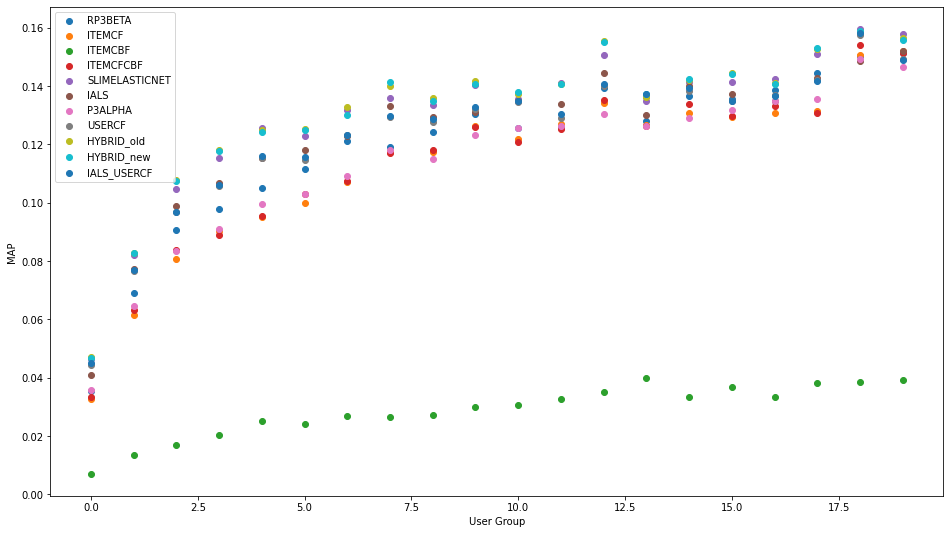

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()